In [1]:
!pip install pyspark
!pip install nltk
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=a95ca7189f9e6954f20f8765ab5e92ae7958f0d386c0038747fc67513bd2d310
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


## Exploration

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from pyspark import SparkFiles
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, StringType
from matplotlib.ticker import MaxNLocator

plt.style.use("seaborn-white")
plt.rc("figure", figsize=(10.0, 10.0))

/tmp/ipykernel_18/2595896629.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


In [3]:
spark = SparkSession.builder.master("local").appName("Traffic").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/07 11:35:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
df = spark.read.option("quote", '"').option("escape", '"').option("multiline", "true")\
    .csv("Traffic_Violations.csv", header=True, inferSchema=True)
df.show(vertical=True, n=1)

24/05/07 11:35:54 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


-RECORD 0---------------------------------------
 Date Of Stop            | 09/24/2013           
 Time Of Stop            | 2024-05-07 17:11:00  
 Agency                  | MCP                  
 SubAgency               | 3rd district, Sil... 
 Description             | DRIVING VEHICLE O... 
 Location                | 8804 FLOWER AVE      
 Latitude                | NULL                 
 Longitude               | NULL                 
 Accident                | No                   
 Belts                   | No                   
 Personal Injury         | No                   
 Property Damage         | No                   
 Fatal                   | No                   
 Commercial License      | No                   
 HAZMAT                  | No                   
 Commercial Vehicle      | No                   
 Alcohol                 | No                   
 Work Zone               | No                   
 State                   | MD                   
 VehicleType        

In [5]:
# Combine Electric Safety Equipment Repair Order with Safety Equipment Repair Order
df = df.replace("ESERO", "SERO", "Violation Type")
# Fix Make
df = df.replace("TOYT", "TOYOTA", "Make")
df = df.replace("HOND", "HONDA", "Make")
df = df.replace("NISS", "NISSAN", "Make")
df = df.replace("CHEV", "CHEVY", "Make")
df = df.replace("CHEVY", "CHEVROLET", "Make")
df = df.replace("HYUN", "HYUNDAI", "Make")
df = df.replace("ACUR", "ACURA", "Make")
df = df.replace("MERZ", "MERCEDES", "Make")
df = df.replace("LEXU", "LEXUS", "Make")
# DateTime conversion
df = df.withColumn("Date Of Stop", F.to_date("Date Of Stop", "MM/dd/yyyy"))
df = df.withColumn("Time Of Stop", F.to_timestamp("Time Of Stop", "HH:mm:ss"))
df = df.withColumn("Year Of Stop", F.year("Date Of Stop"))

df = df.dropDuplicates()
df.count()

24/05/07 11:36:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/07 11:36:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


1017320

In [6]:
# As the charge type is too complicated, only the big categories are considered in their short form.
def simplify_charge_impl(charge):
    if "-" in charge:
        dot_index = charge.find(".")
        if dot_index > -1:
            charge = charge[:dot_index]
        bracket_index = charge.find("(")
        if bracket_index > -1:
            charge = charge[:bracket_index]
    return charge

# spark.udf.register("simplify_charge", simplify_charge_impl, StringType())
simplify_charge = F.udf(simplify_charge_impl)
df = df.withColumn("ShortCharge", simplify_charge("Charge"))
df.select("ShortCharge").distinct().count()
charge_count = df.groupBy("ShortCharge").count().orderBy("count", ascending=False)

353

24/05/07 11:36:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/07 11:36:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


<Axes: xlabel='Type of Charge', ylabel='#Violations'>

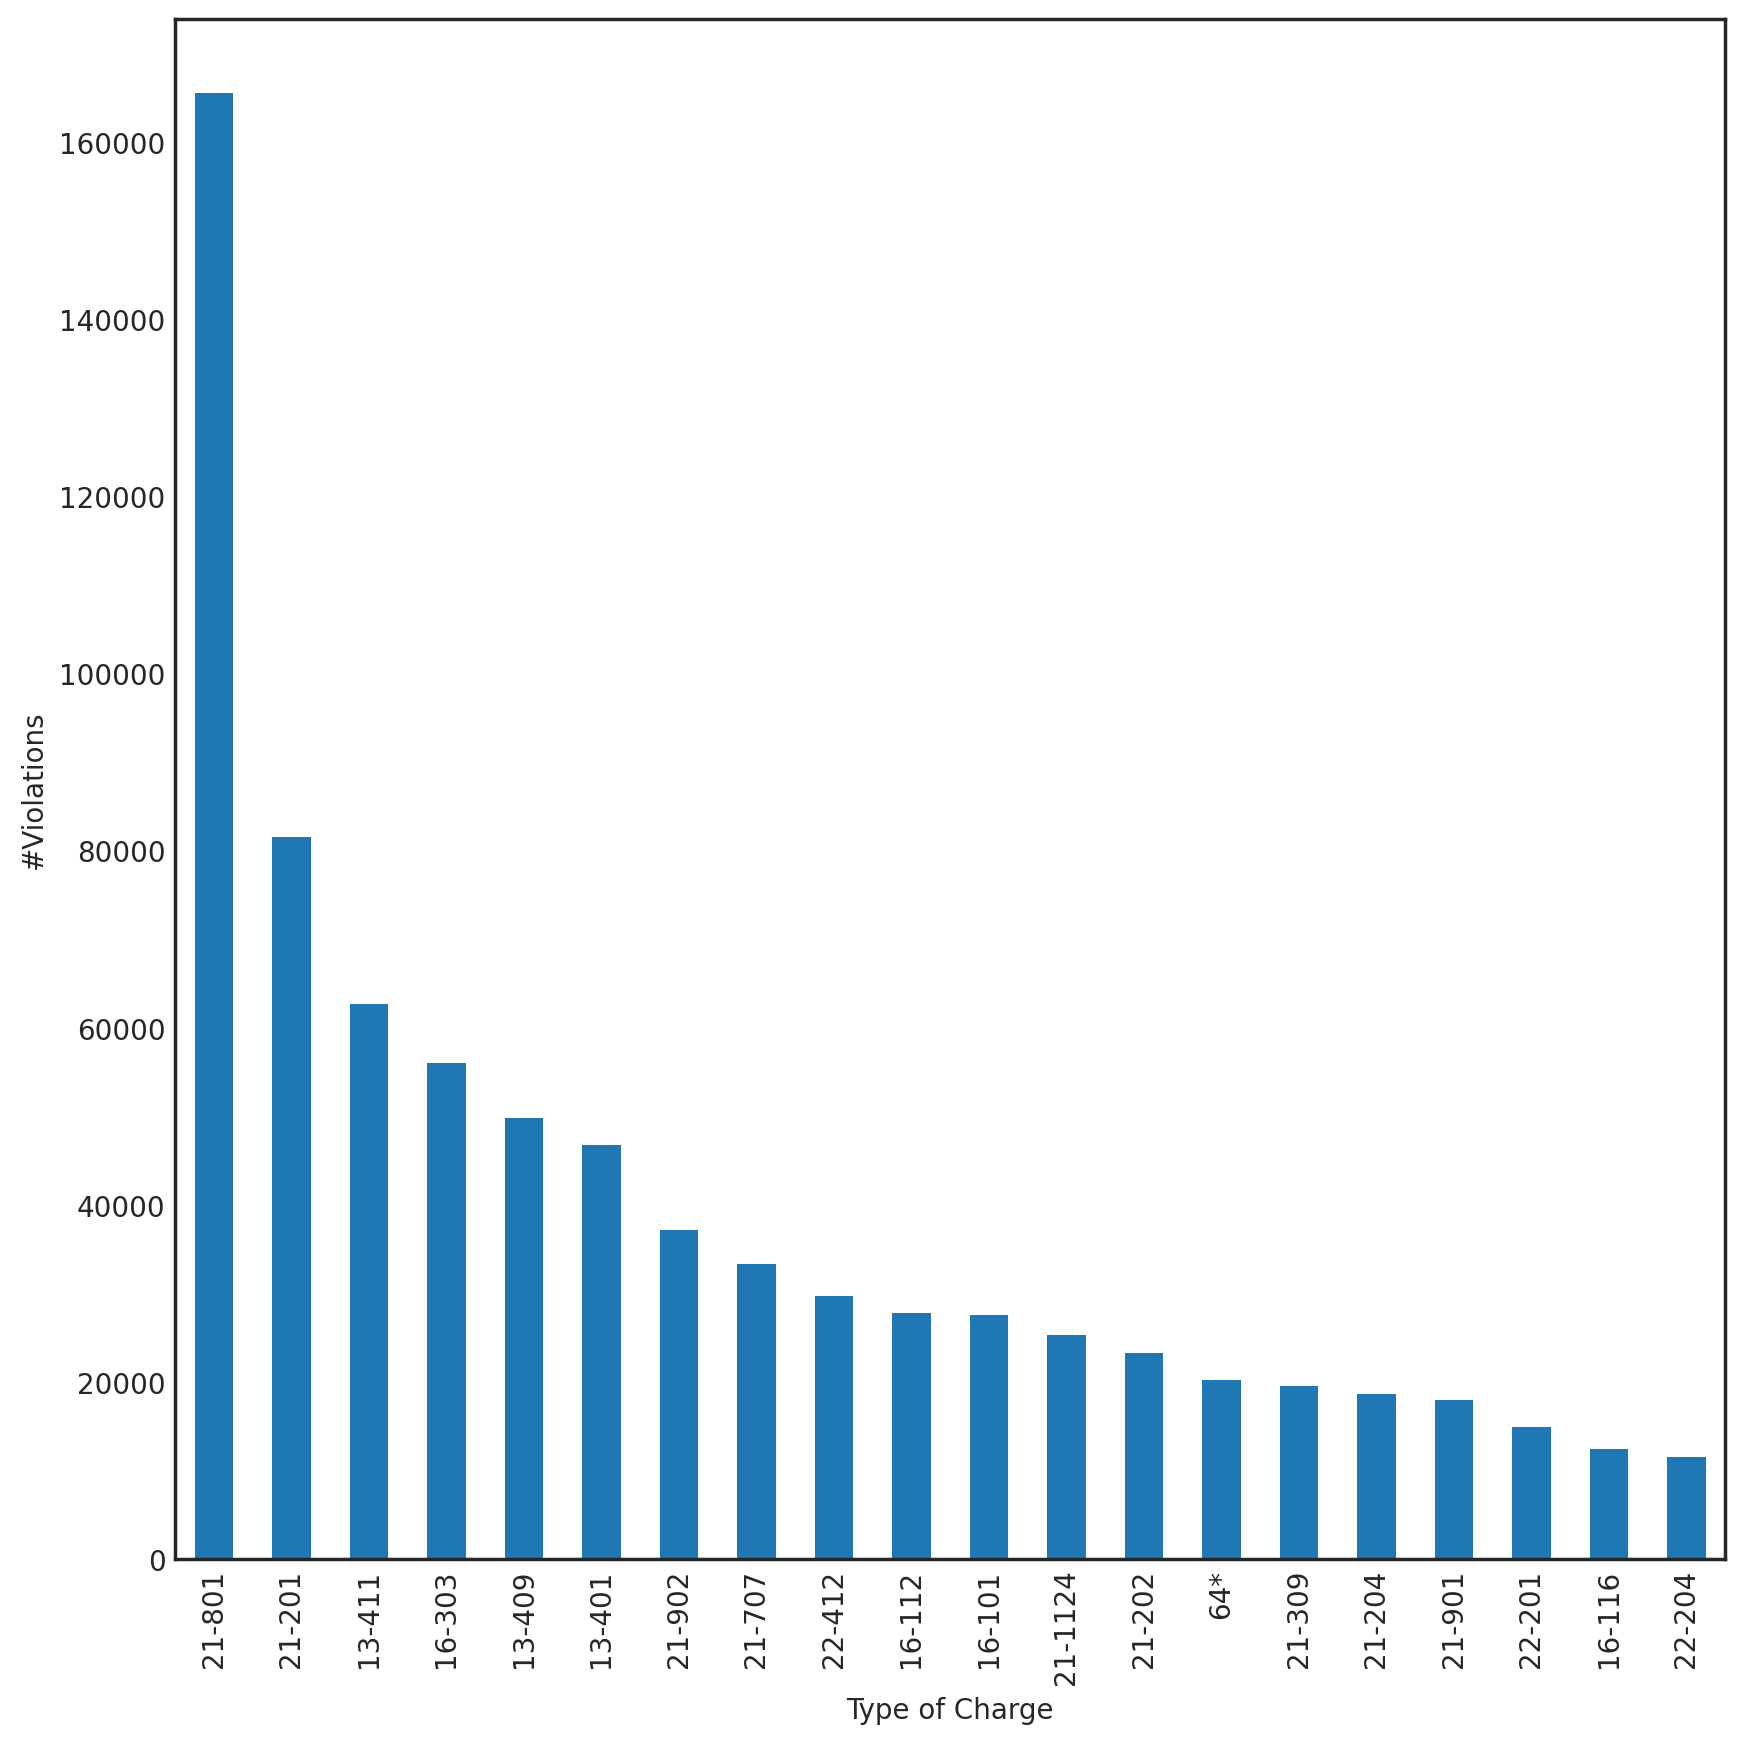

In [7]:
charge_count_pd = charge_count.toPandas()
charge_count_pd = charge_count_pd.head(20)
charge_count_pd.plot.bar("ShortCharge", "count", legend=False, xlabel="Type of Charge", ylabel="#Violations")

# Based on Charge, we can know the description of the violation. For example:
# 21-801: Speeding Violations
# 21-201: Running Red Lights

24/05/07 11:37:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/07 11:37:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


<Axes: xlabel='State', ylabel='#Violations'>

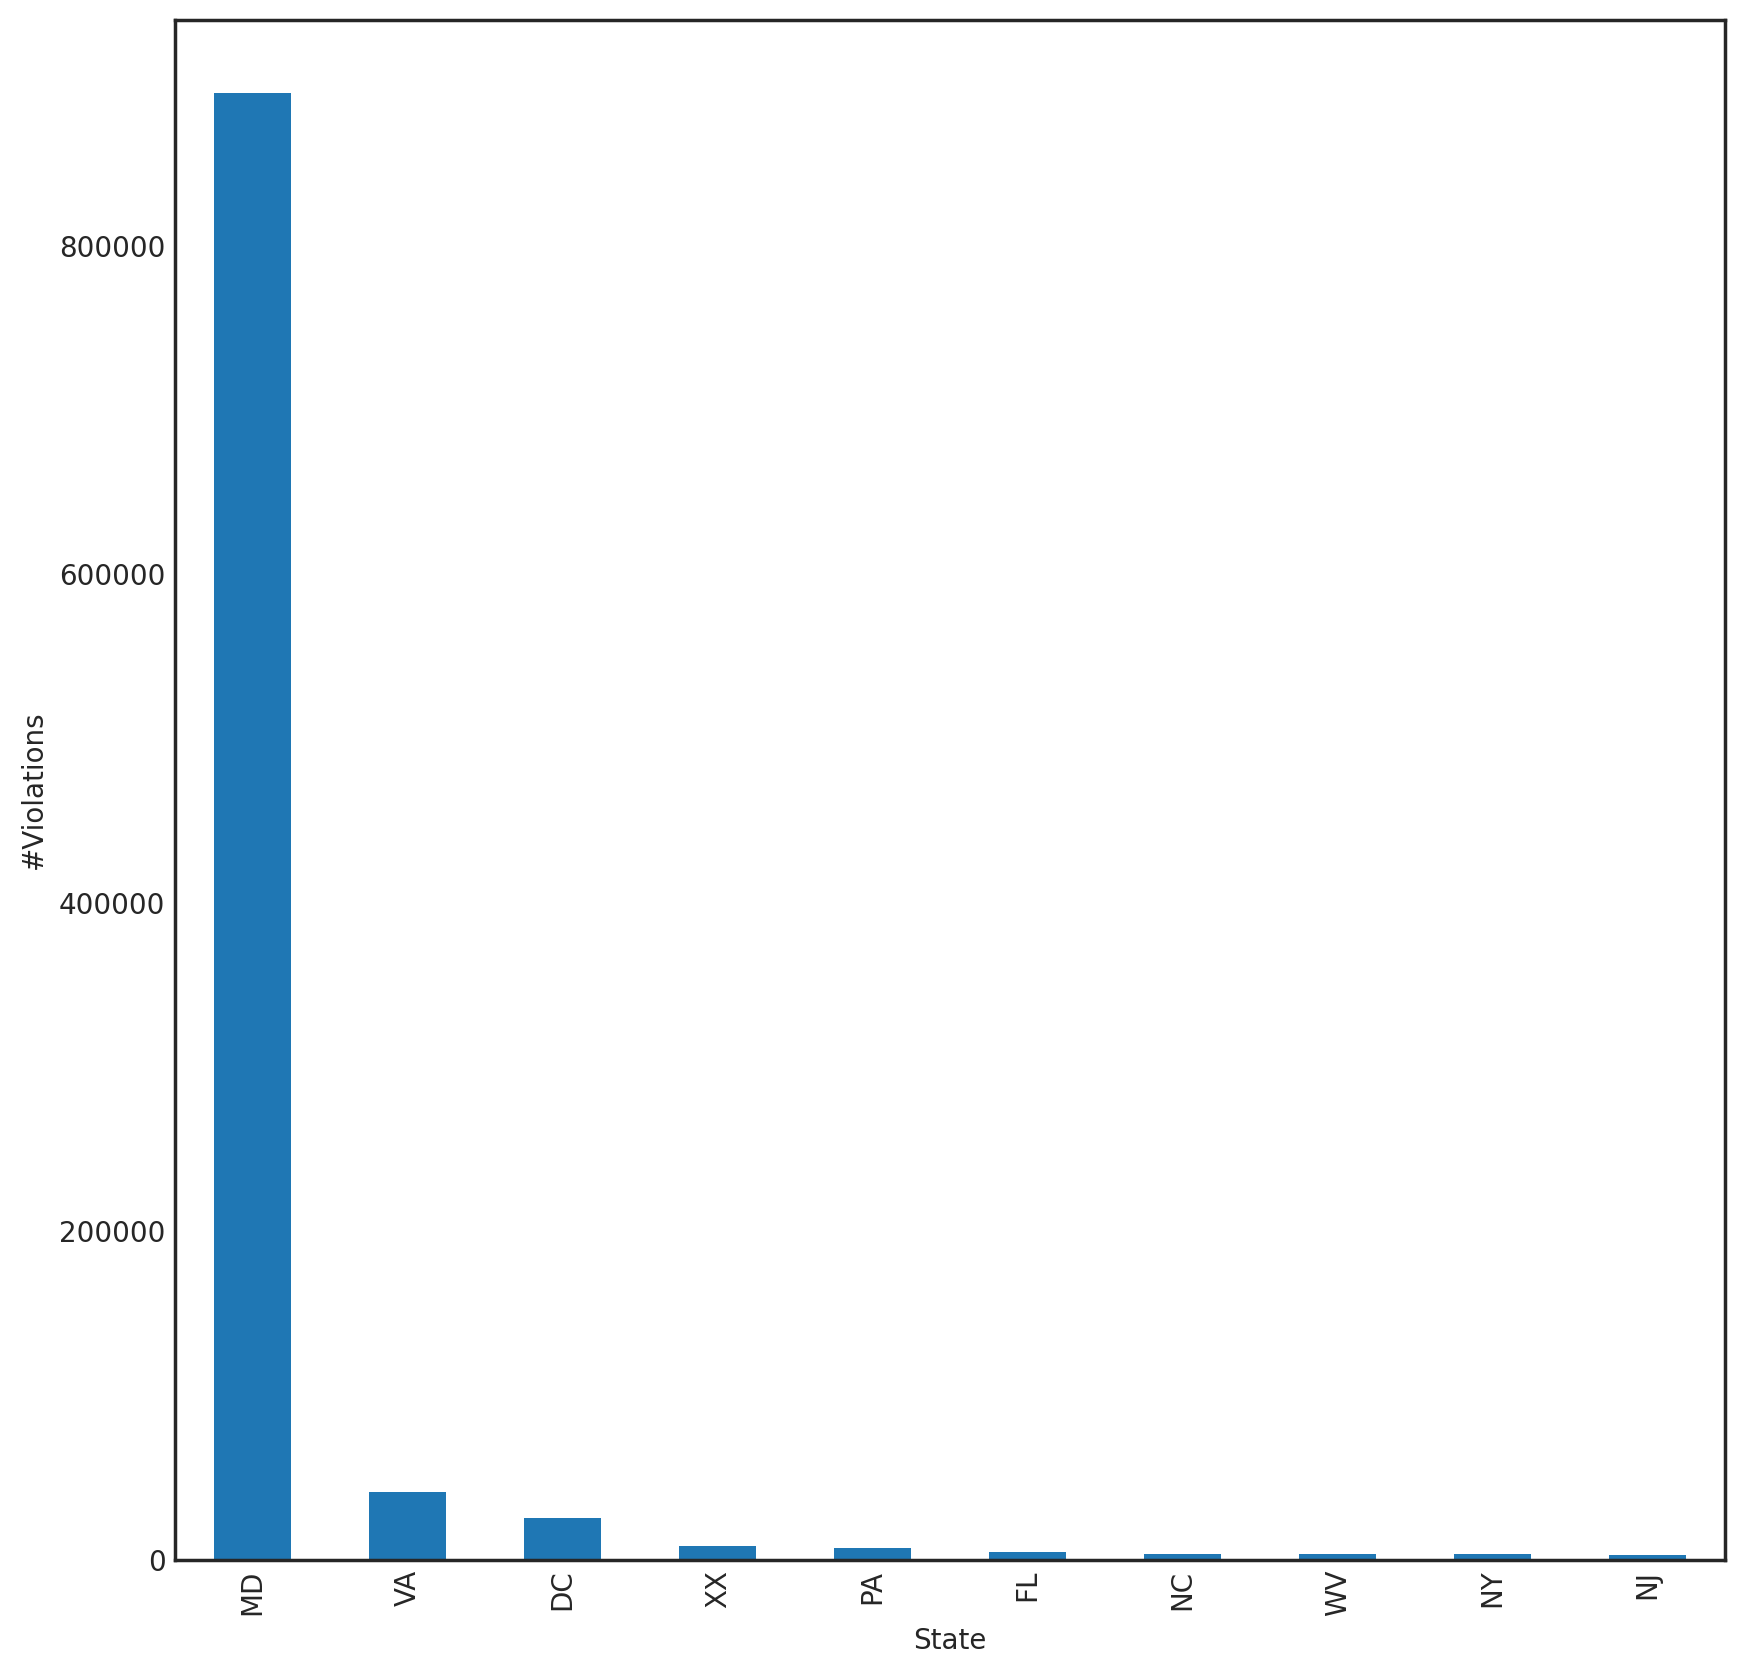

In [8]:
state_count = df.groupBy("State").count().orderBy("count", ascending=False)
state_count_pd = state_count.toPandas()
state_count_pd = state_count_pd.head(10)
state_count_pd.plot.bar("State", "count", legend=False, ylabel="#Violations")

24/05/07 11:38:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/07 11:38:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


<Axes: title={'center': "Violations in driver's home state"}>

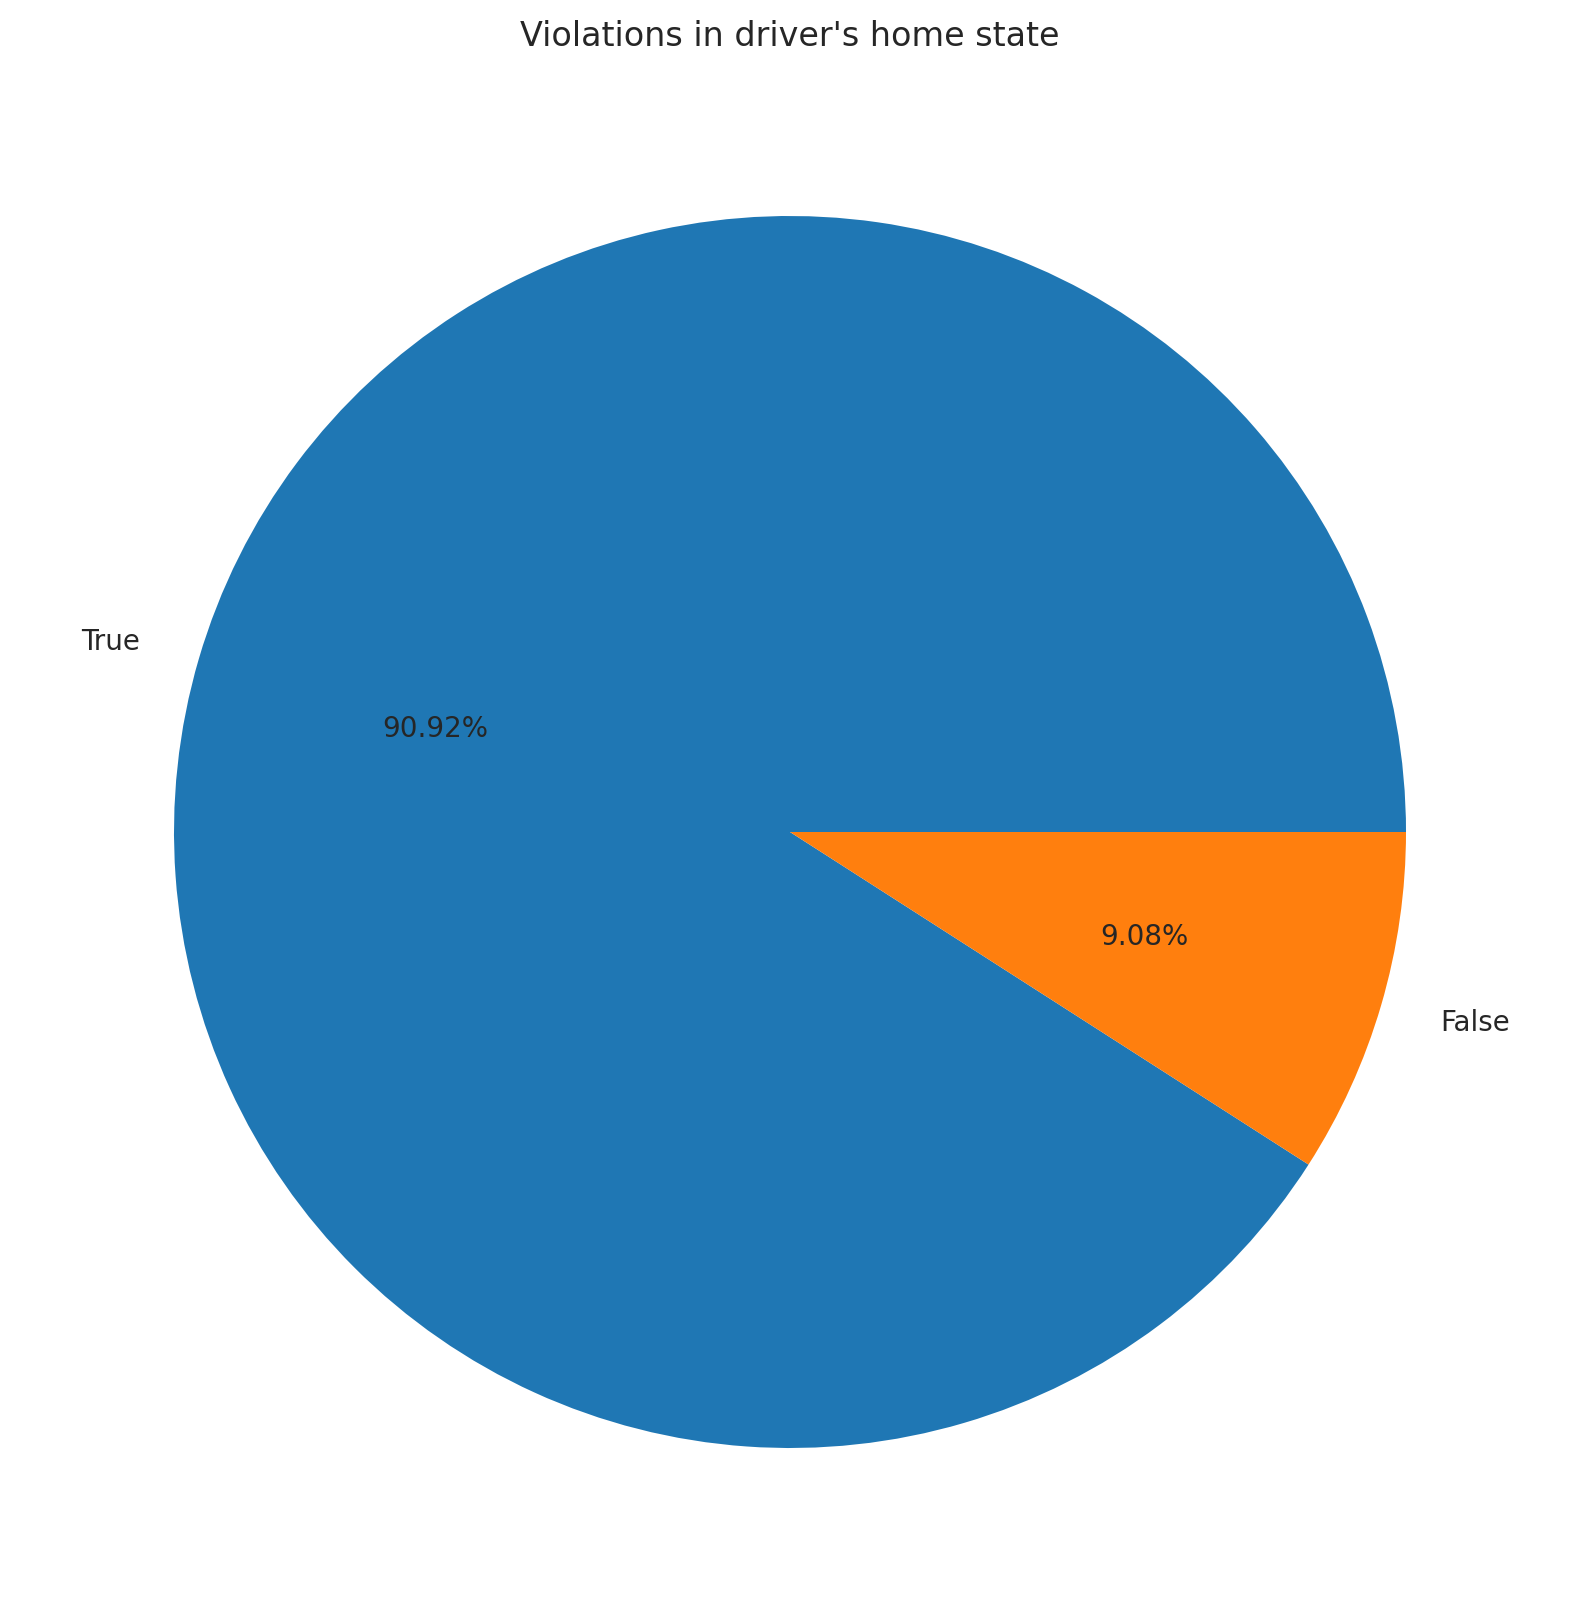

In [9]:
driver_state_df = df.filter(F.col("State").isNotNull()).filter(F.col("Driver State").isNotNull())
driver_state_df = driver_state_df.withColumn("Same State", F.col("State") == F.col("Driver State"))
drive_state_count = driver_state_df.groupBy("Same State").count()
drive_state_pd = drive_state_count.toPandas()
drive_state_pd = drive_state_pd.set_index("Same State")
drive_state_pd.plot.pie(
    y="count",
    autopct="%1.2f%%", legend=False, ylabel="",
    title="Violations in driver's home state",
)

24/05/07 11:38:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/07 11:38:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


<Axes: title={'center': 'Violations by Race'}>

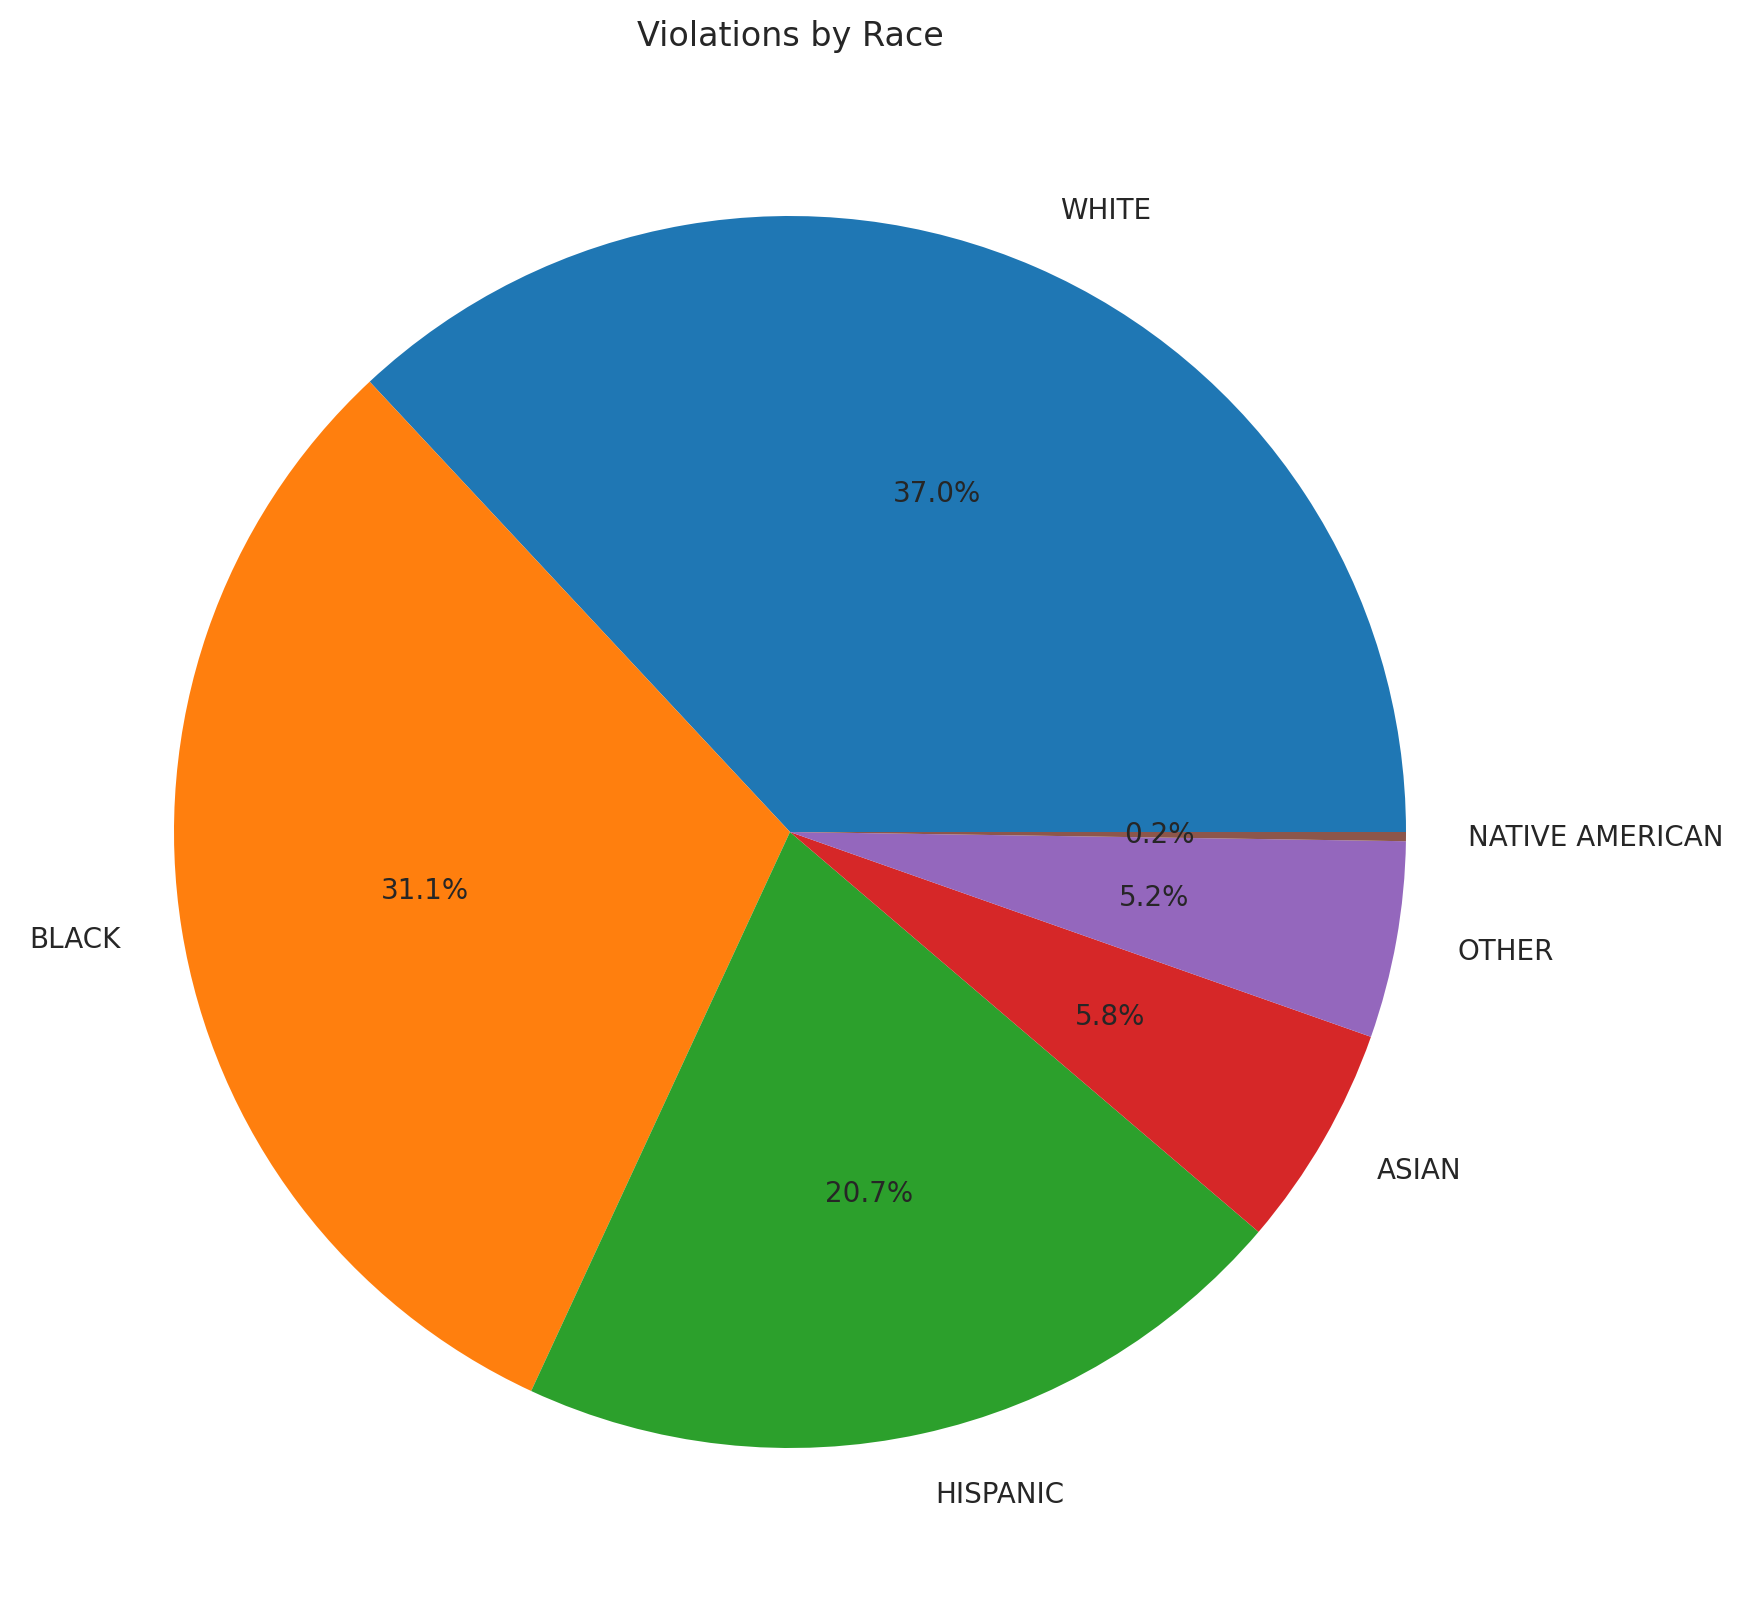

In [10]:
race_count = df.groupBy("Race").count().orderBy("count", ascending=False)
gender_count = df.groupBy("Gender").count().orderBy("count", ascending=False)
race_count_pd = race_count.toPandas()
race_count_pd = race_count_pd.set_index("Race")
race_count_pd.plot.pie(
    y="count",
    autopct="%1.1f%%", legend=False, ylabel="",
    title="Violations by Race",
)

24/05/07 11:39:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/07 11:39:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


<Axes: title={'center': 'Violations by Gender'}>

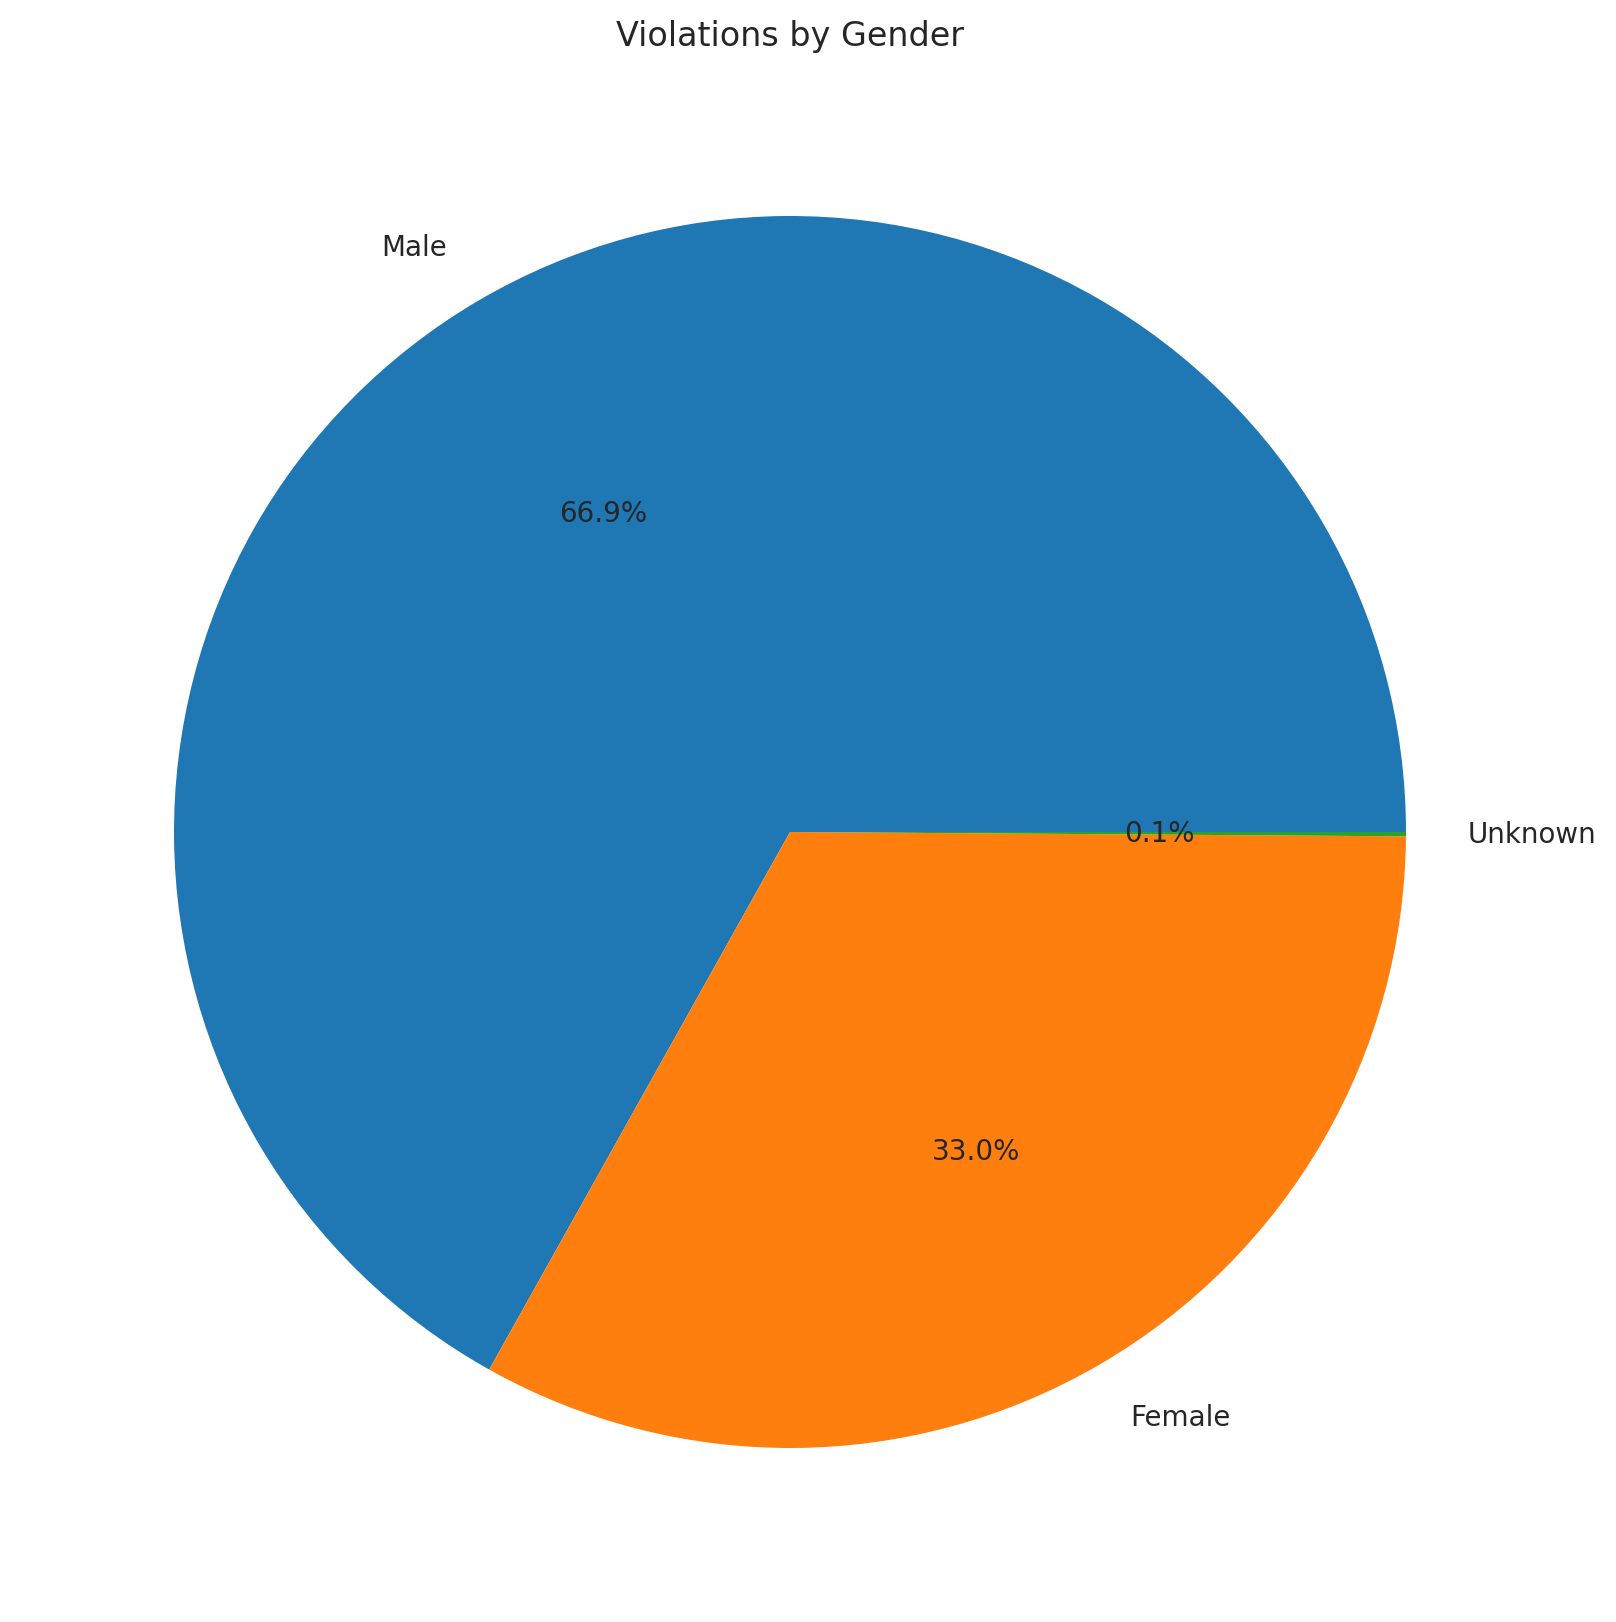

In [11]:
gender_count_pd = gender_count.toPandas()
gender_count_pd = gender_count_pd.set_index("Gender")
gender_count_pd.plot.pie(
    y="count",
    autopct="%1.1f%%", legend=False, ylabel="",
    title="Violations by Gender",
    labels=["Male", "Female", "Unknown"],
)

In [12]:
def hour_to_quarter_impl(hour):
    if 0 <= hour < 6:
        return 0
    elif 6 <= hour < 9:
        return 1
    elif 9 <= hour < 12:
        return 2
    elif 12 <= hour < 18:
        return 3
    elif 18 <= hour < 21:
        return 4
    elif 21 <= hour:
        return 5
    return -1

# Find weekday and year
df = df.withColumn("Weekday", F.dayofweek("Date Of Stop"))
df.select("Weekday").distinct().show()
df.select("Year of Stop").distinct().count()
df.agg({"Date Of Stop": "max"}).collect()[0]
# Find hour
df = df.withColumn("Hour", F.hour("Time Of Stop"))
df.select("Hour").distinct().count()
hour_to_quarter = F.udf(hour_to_quarter_impl)
df = df.withColumn("Hour Quarter", hour_to_quarter("Hour"))
df.select("Hour Quarter").distinct().count()

+-------+
|Weekday|
+-------+
|      1|
|      6|
|      3|
|      5|
|      4|
|      7|
|      2|
+-------+



5

Row(max(Date Of Stop)=datetime.date(2016, 12, 27))

24

6

24/05/07 11:40:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/07 11:40:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


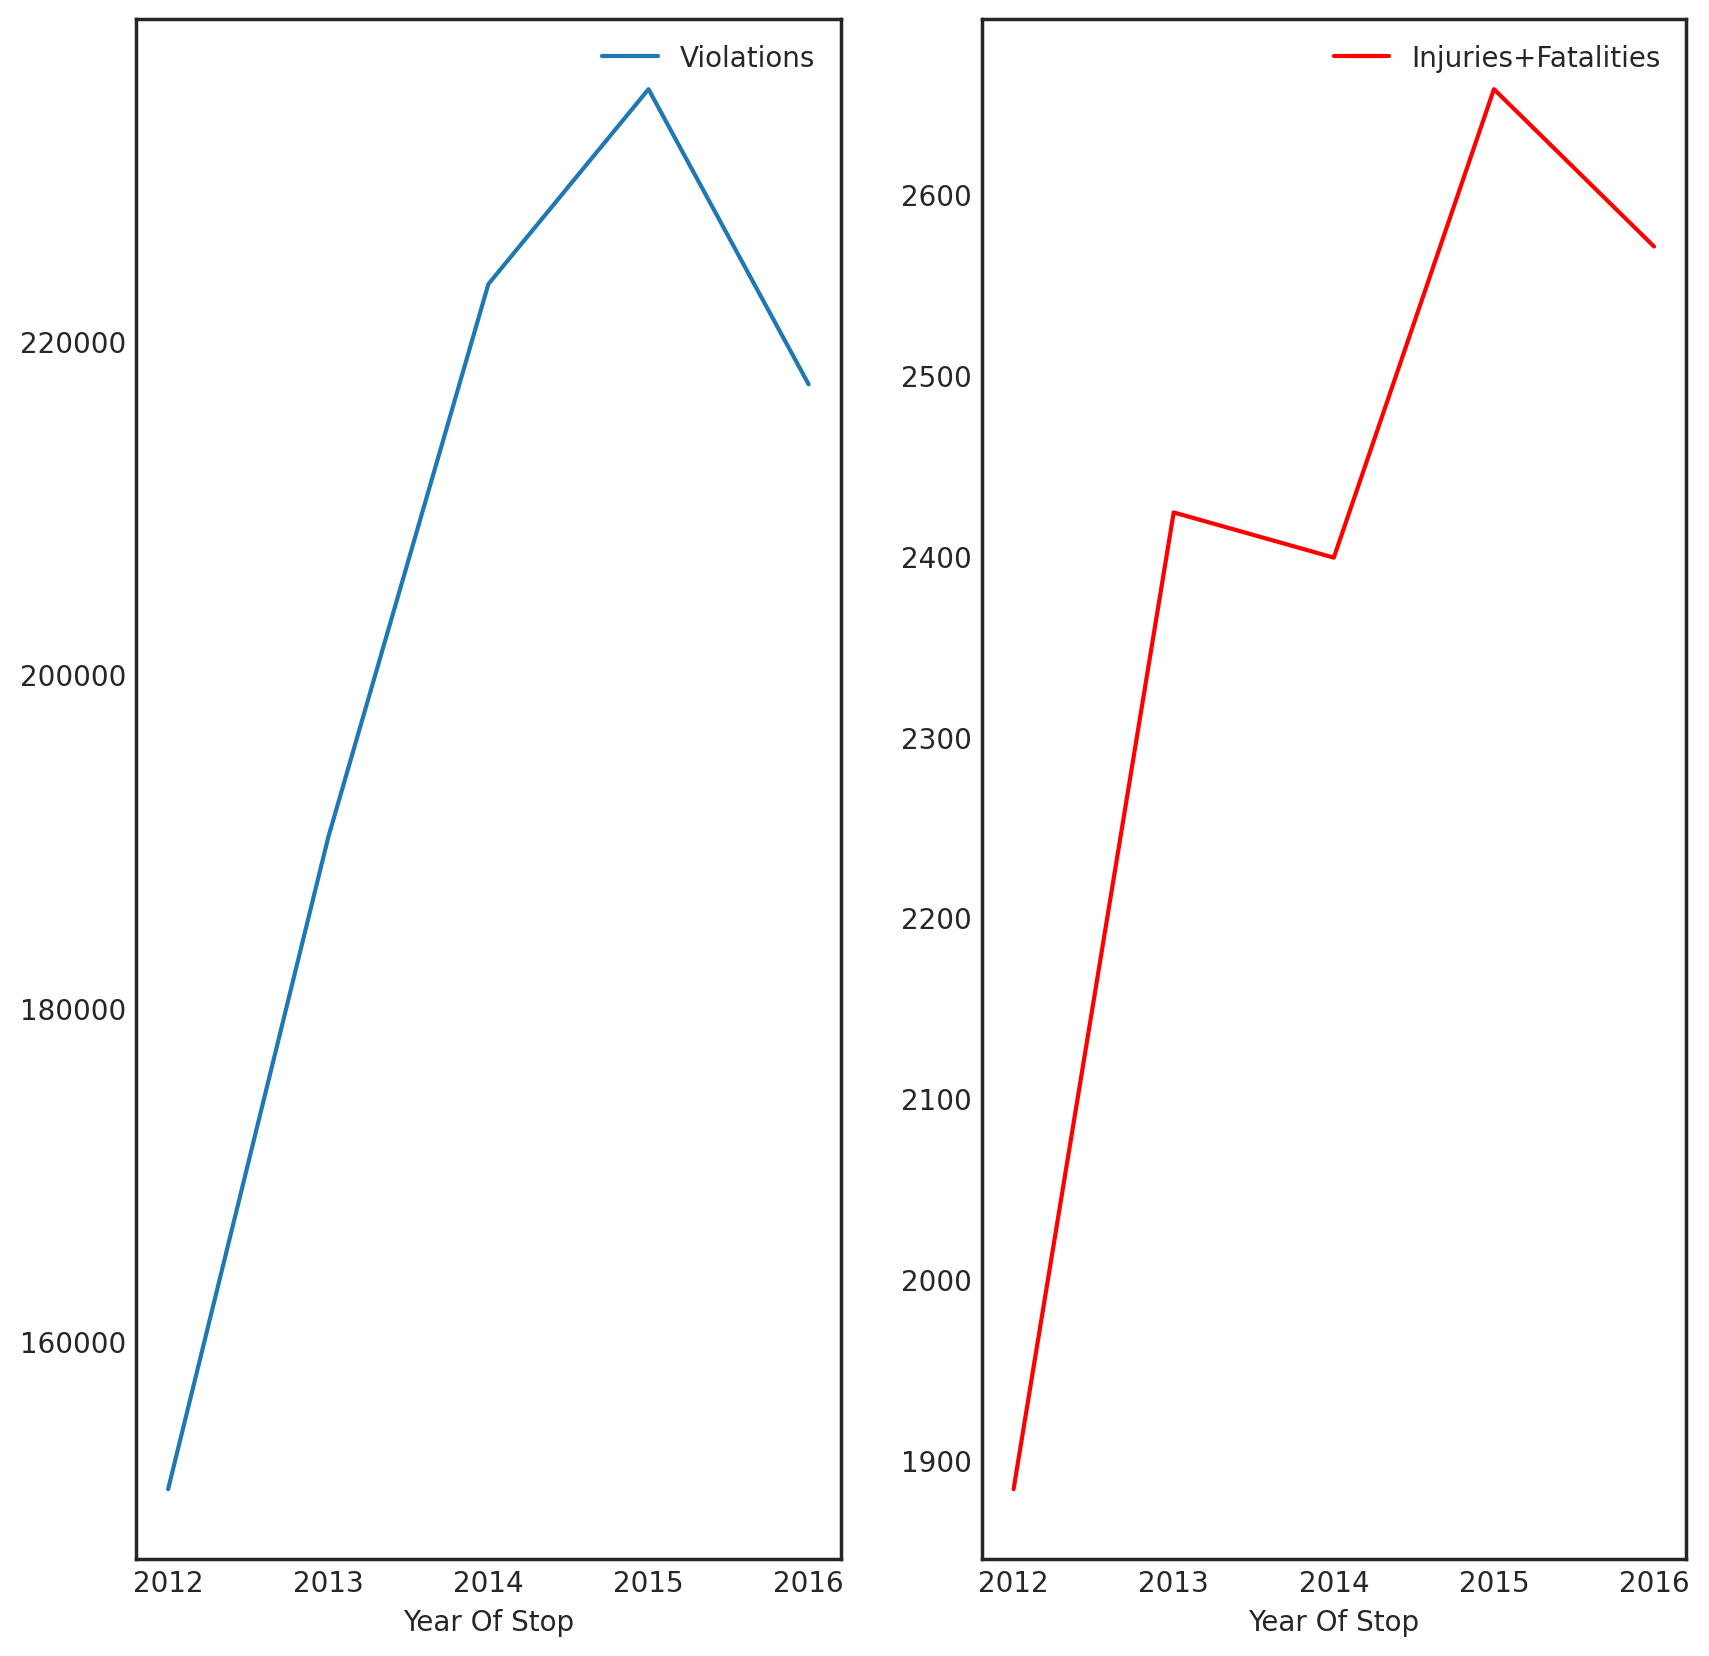

In [13]:
year_count = df.groupBy("Year Of Stop").count().orderBy("Year Of Stop", ascending=True)
fatal_year_count = df.where((F.col("Fatal") == "Yes") | (F.col("Personal Injury") == "Yes")).groupBy("Year Of Stop").count().orderBy("Year Of Stop", ascending=True)
fatal_year_count = fatal_year_count.withColumnRenamed("count", "fatal_count")
year_count = year_count.join(fatal_year_count, on=["Year Of Stop"]).orderBy("Year Of Stop", ascending=True)
year_count_pd = year_count.toPandas()
fig, axes = plt.subplots(1, 2)
ax = year_count_pd.plot.line(
    ax=axes[0],
    x="Year Of Stop", y="count",
    legend=True,
)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(["Violations"])
ax = year_count_pd.plot.line(
    ax=axes[1],
    x="Year Of Stop", y="fatal_count",
    legend=True, color="red",
)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(["Injuries+Fatalities"])

24/05/07 11:41:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


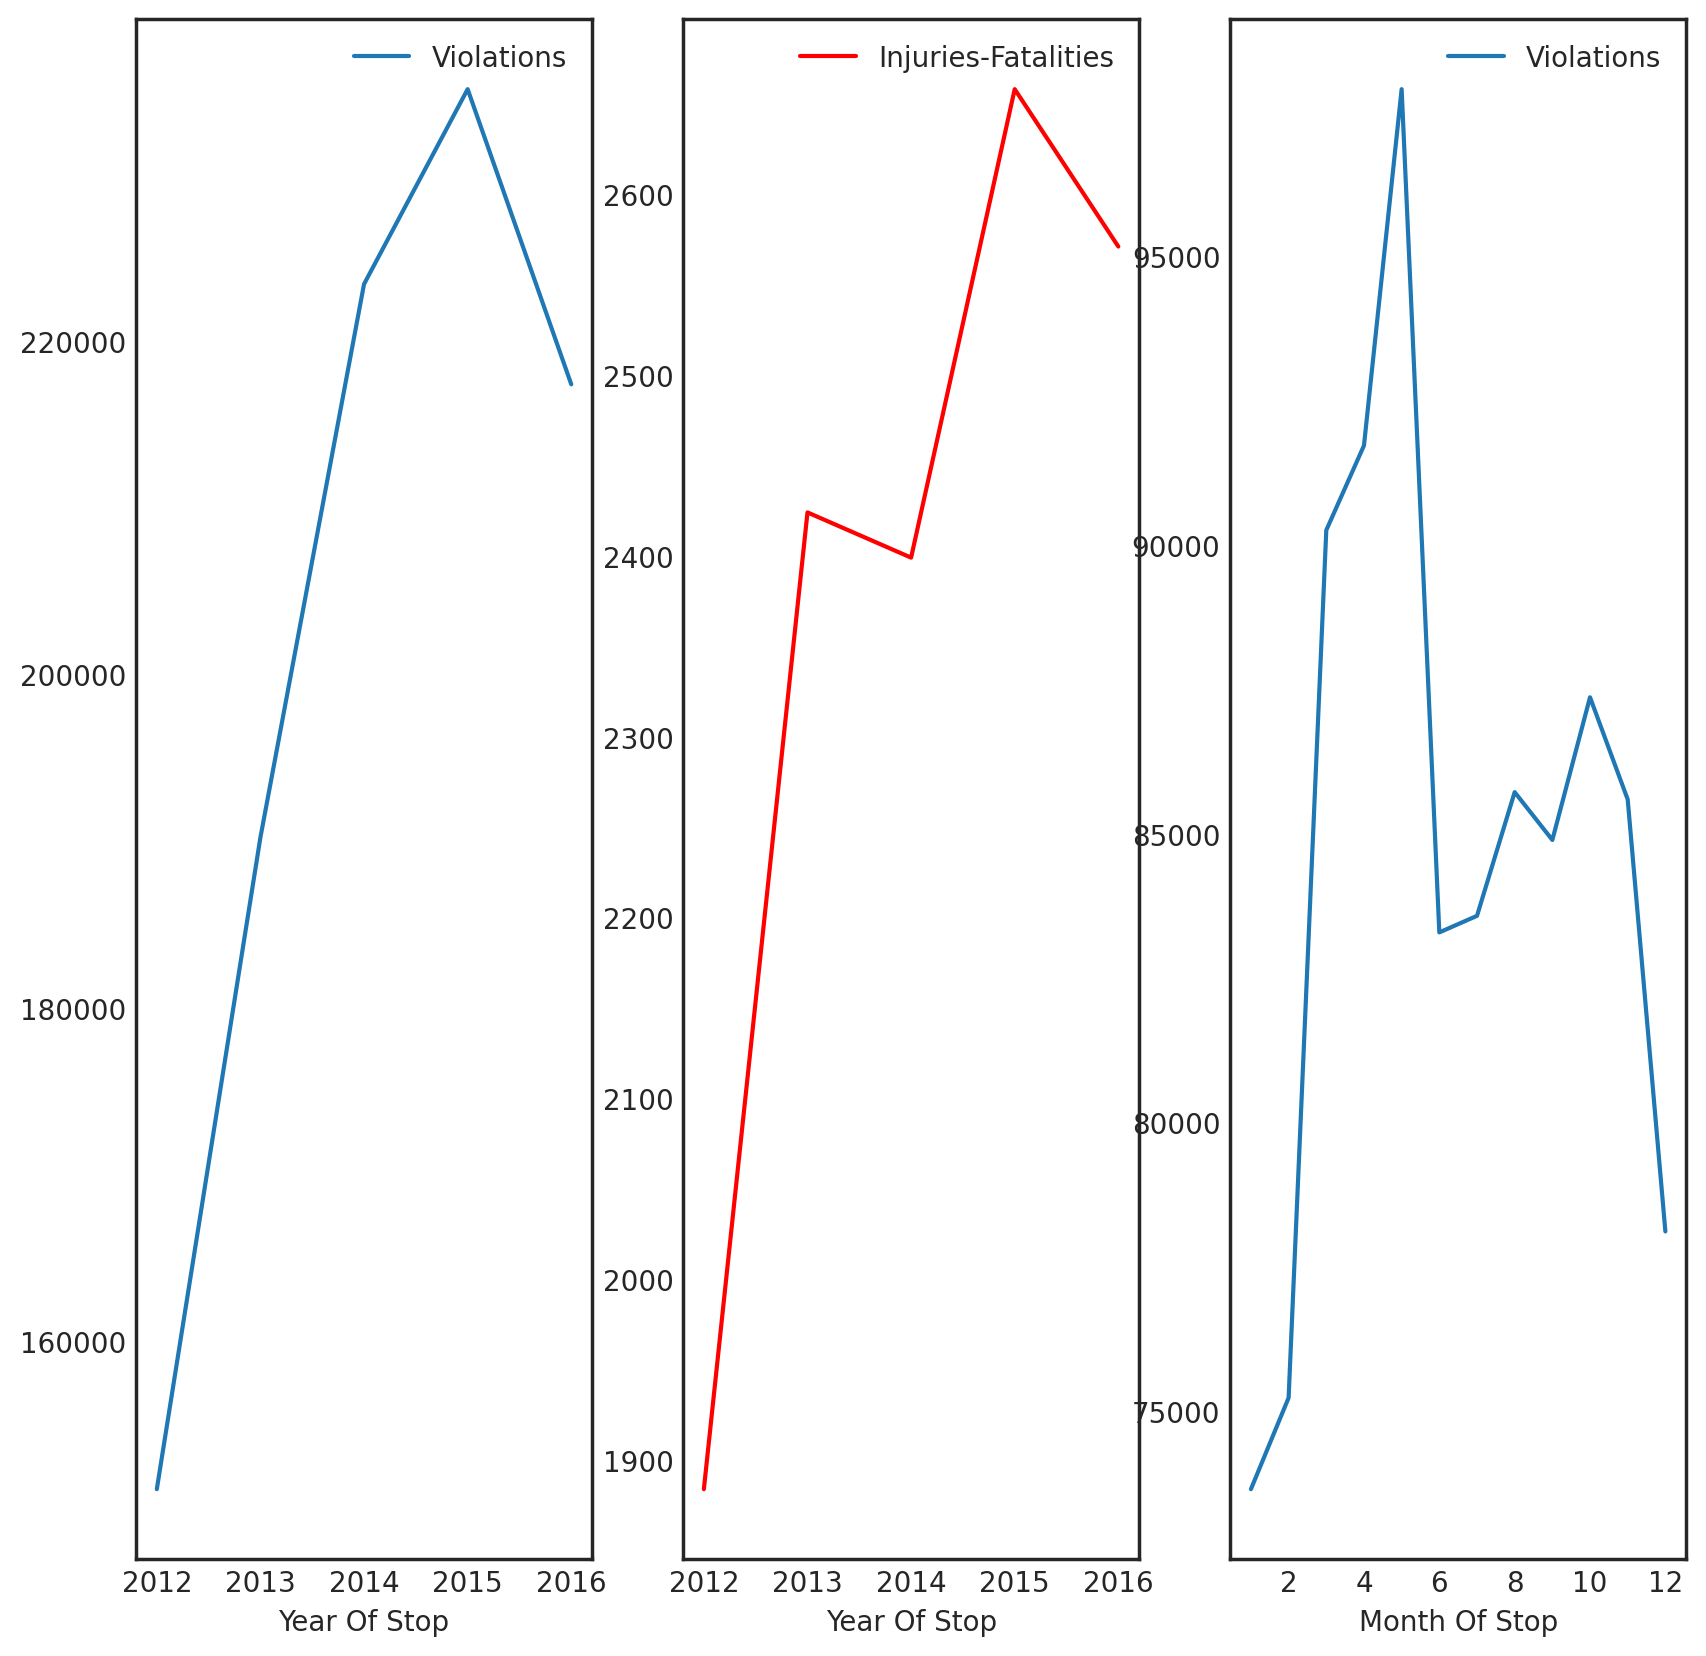

In [14]:
df = df.withColumn("Month Of Stop", F.month("Date Of Stop"))
month_count = df.groupBy("Month Of Stop").count().orderBy("Month Of Stop", ascending=True)
month_count_pd = month_count.toPandas()
fig, axes = plt.subplots(1, 3)
ax = year_count_pd.plot.line(
    ax=axes[0],
    x="Year Of Stop", y="count",
    legend=True,
)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(["Violations"])
ax = year_count_pd.plot.line(
    ax=axes[1],
    x="Year Of Stop", y="fatal_count",
    legend=True, color="red",
)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(["Injuries-Fatalities"])
ax = month_count_pd.plot.line(
    ax=axes[2],
    x="Month Of Stop", y="count",
    legend=True,
)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(["Violations"])

24/05/07 11:41:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


[Text(0.5, 85.58333333333331, 'Hours'),
 Text(100.58333333333333, 0.5, 'Day of Week')]

Text(0.5, 1.0, 'Violations across a Week')

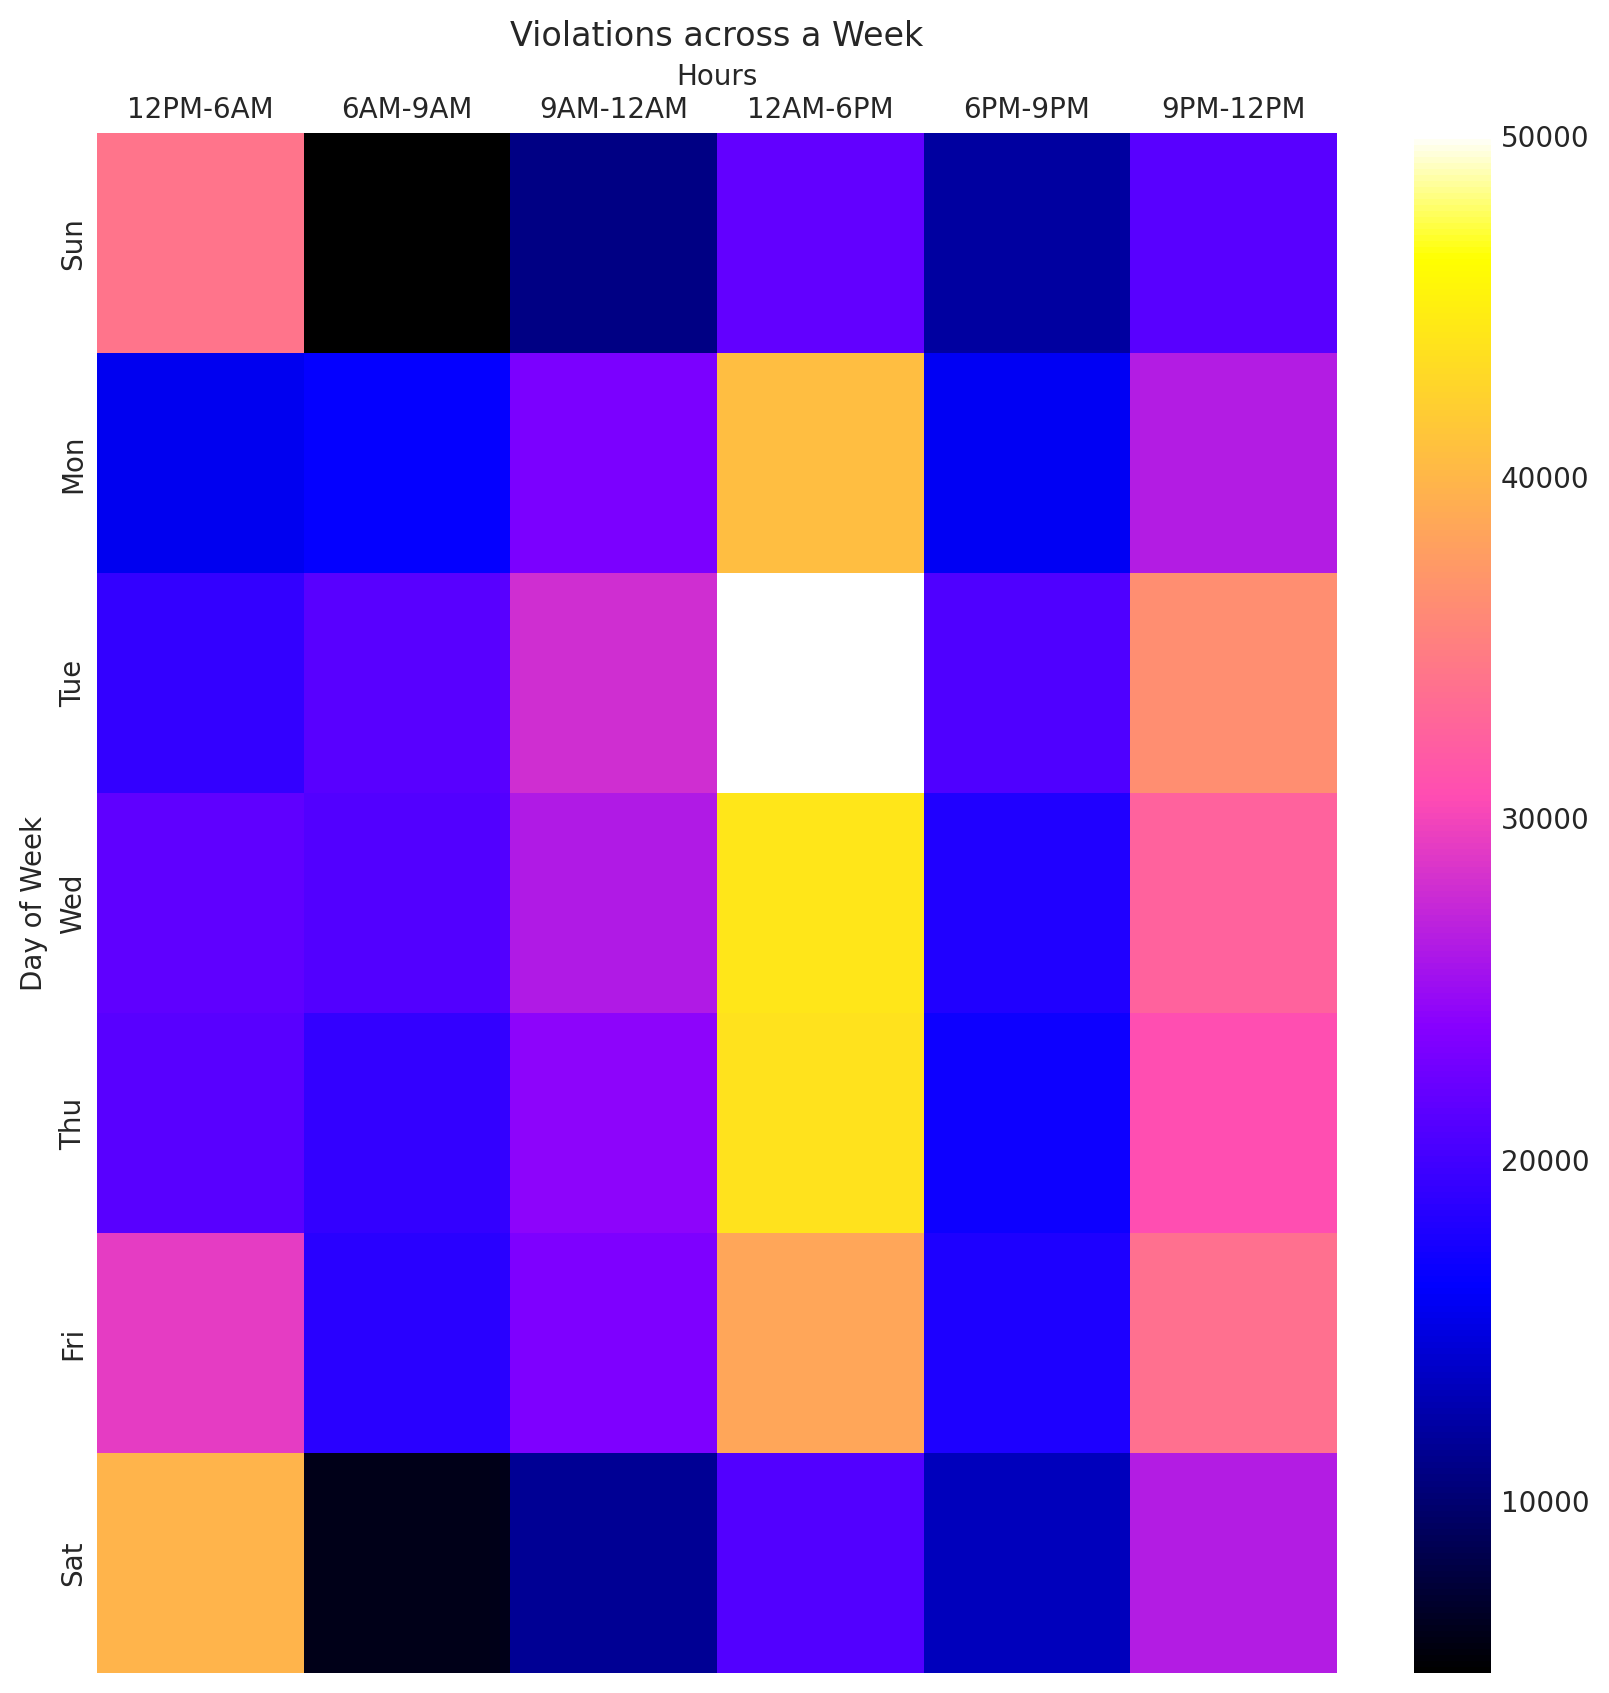

In [15]:
weekday_hour_count = df.groupBy(["Weekday", "Hour Quarter"]).count().orderBy(["Weekday", "Hour Quarter"], ascending=True)
weekday_hour_count_pd = weekday_hour_count.toPandas()
weekday_hour_count_pd = weekday_hour_count_pd.pivot(index="Weekday", columns="Hour Quarter", values="count")
ax = seaborn.heatmap(
    data=weekday_hour_count_pd,
    cmap="gnuplot2",
    yticklabels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    xticklabels=["12PM-6AM", "6AM-9AM", "9AM-12AM", "12AM-6PM", "6PM-9PM", "9PM-12PM"],
)
ax.set(xlabel="Hours", ylabel="Day of Week")
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.set_title("Violations across a Week")

24/05/07 11:42:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/07 11:42:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/07 11:42:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


<Axes: title={'center': 'Cars by Color from M'}>

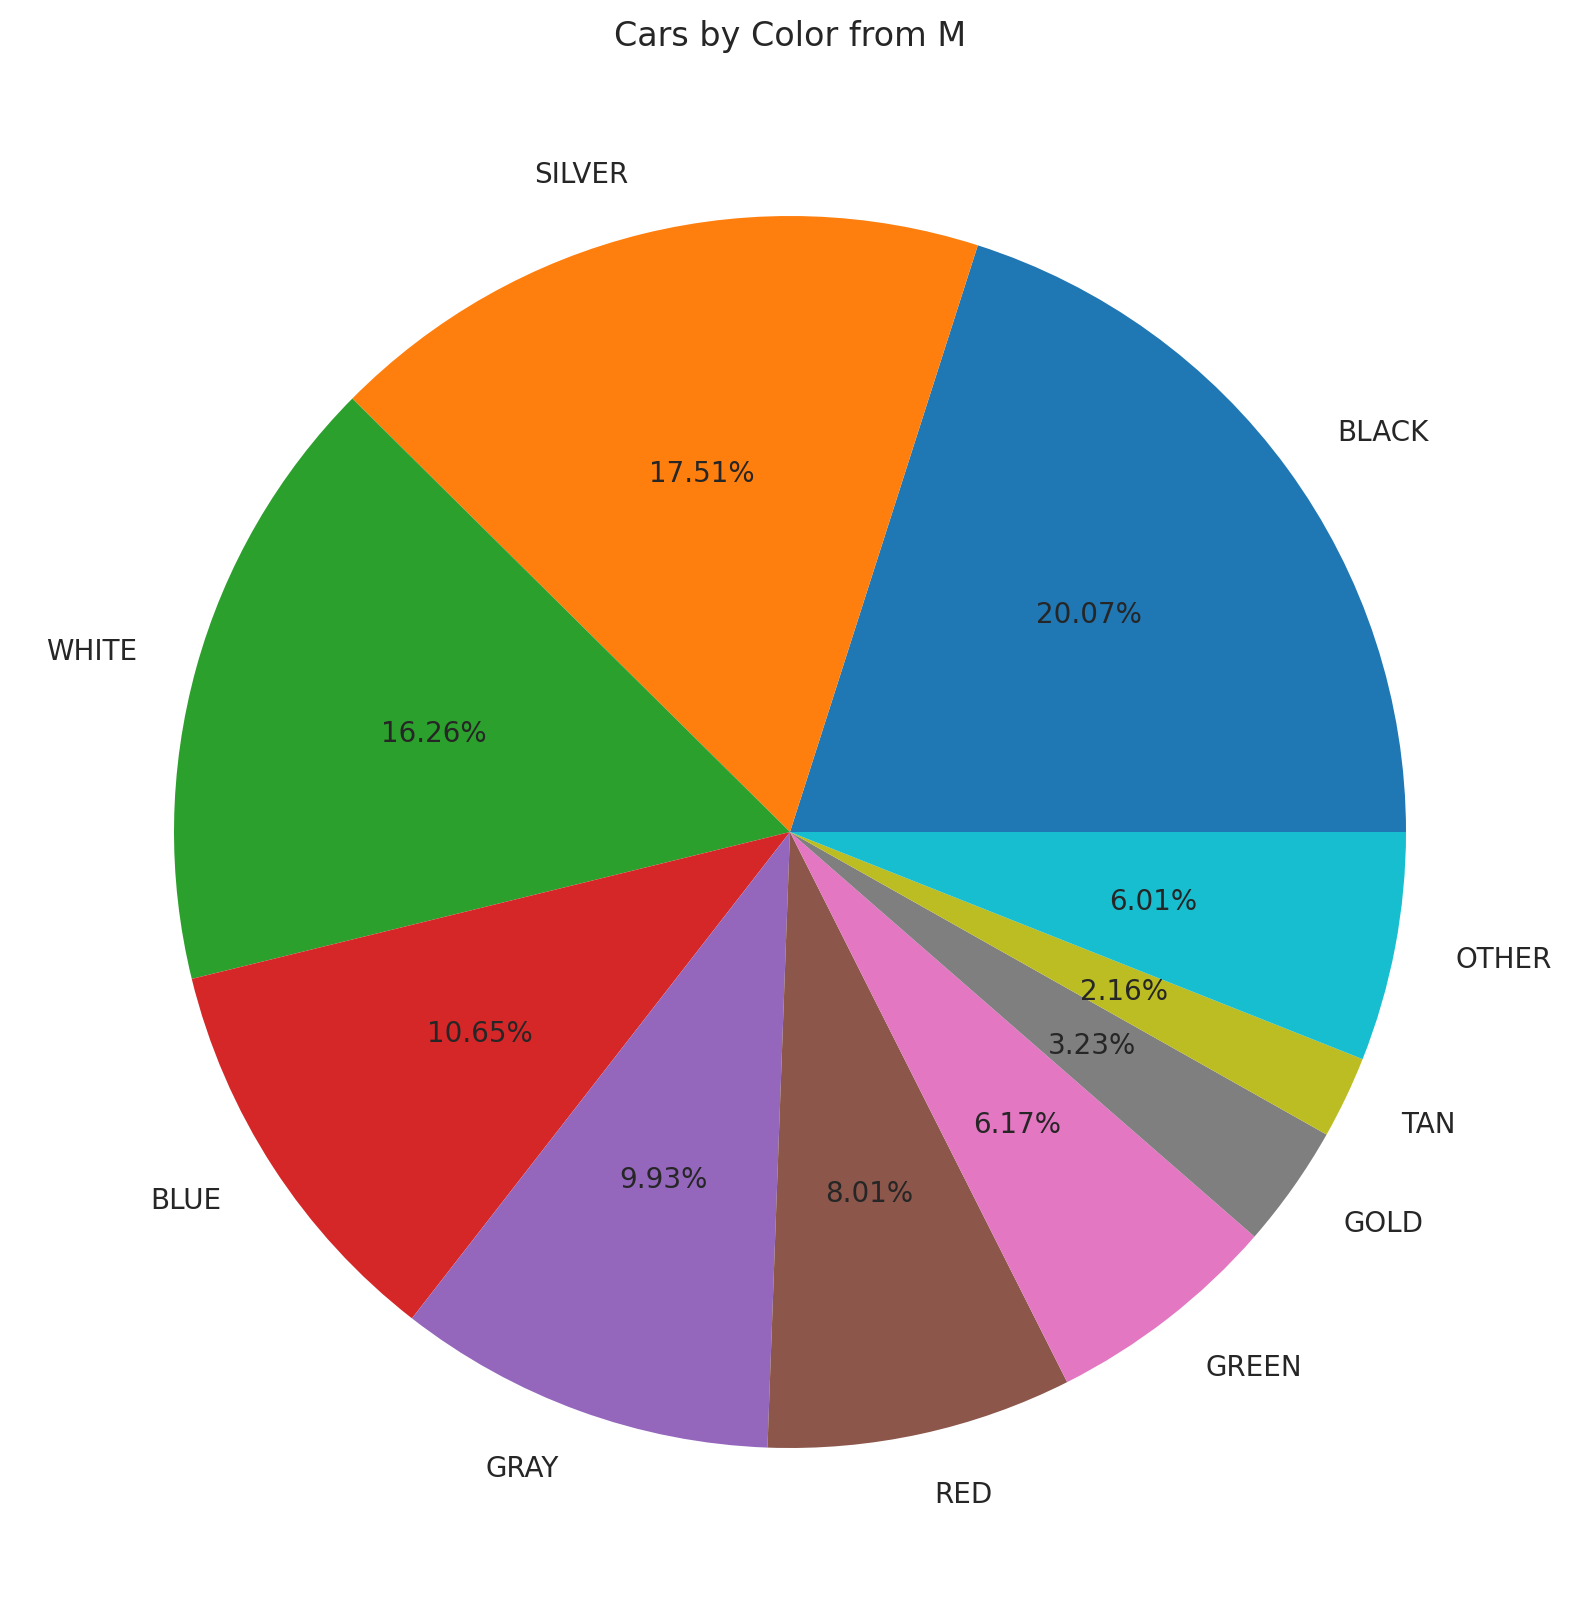

In [16]:
def get_newness_impl(vehicle_year):
    if vehicle_year is None:
        return None
    elif vehicle_year >= 2015:
        return "New"
    elif vehicle_year < 2015 and vehicle_year >= 2000:
        return "Old"
    elif vehicle_year < 2000 and vehicle_year >= 1950:
        return "Very Old"    
    return "Antique"

def simplify_color_impl(color):
    if color is None:
        return None
    elif "," in color:
        index = color.find(",")
        color = color[:index]
    return color

get_newness = F.udf(get_newness_impl)
simplify_color = F.udf(simplify_color_impl)
df = df.withColumn("Newness", get_newness("Year"))
df = df.withColumn("Color", simplify_color("Color"))

car_col = "Color"
human_col = "Gender"
human_value = "M"

car_df = df.filter(F.col(human_col).isNotNull()).filter(F.col(car_col).isNotNull())
car_df = car_df.filter(F.col(human_col) == human_value).groupBy(car_col).count().orderBy("count", ascending=False)

car_pd = car_df.toPandas()
other_index = {"Make": 11, "Color": 9}.get(car_col, 16)
if len(car_pd) > other_index:
    sum_other_rows = car_pd.iloc[other_index:].sum(numeric_only=True)
    car_pd.loc[other_index, car_col] = "OTHER"
    car_pd.loc[other_index, "count"] = sum_other_rows.iloc[0]
    car_pd = car_pd.drop(range(other_index + 1, len(car_pd)))

car_pd = car_pd.set_index(car_col)
car_pd.plot.pie(
    y="count",
    autopct="%1.2f%%", legend=False,
    title=f"Cars by {car_col} from {human_value}",
    ylabel="",
)

## Description Clustering

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from pyspark import SparkFiles
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, StringType
from matplotlib.ticker import MaxNLocator
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

In [18]:
df = spark.read.option("quote", '"').option("escape", '"').option("multiline", "true")\
    .csv("/kaggle/input/traffic-violations-in-usa/Traffic_Violations.csv", header=True, inferSchema=True)
df.show(vertical=True, n=1)

-RECORD 0---------------------------------------
 Date Of Stop            | 09/24/2013           
 Time Of Stop            | 2024-05-07 17:11:00  
 Agency                  | MCP                  
 SubAgency               | 3rd district, Sil... 
 Description             | DRIVING VEHICLE O... 
 Location                | 8804 FLOWER AVE      
 Latitude                | NULL                 
 Longitude               | NULL                 
 Accident                | No                   
 Belts                   | No                   
 Personal Injury         | No                   
 Property Damage         | No                   
 Fatal                   | No                   
 Commercial License      | No                   
 HAZMAT                  | No                   
 Commercial Vehicle      | No                   
 Alcohol                 | No                   
 Work Zone               | No                   
 State                   | MD                   
 VehicleType        

In [19]:
download_dir = "/kaggle/working"
nltk.download('punkt', download_dir=download_dir)
nltk.download('stopwords', download_dir=download_dir)
nltk.download('wordnet', download_dir=download_dir)
nltk.data.path.append(download_dir)

[nltk_data] Downloading package punkt to /kaggle/working...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

[nltk_data] Downloading package stopwords to /kaggle/working...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

[nltk_data] Downloading package wordnet to /kaggle/working...


True

In [20]:
!unzip -q -o /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora

In [21]:
description_column = df.select('Description')
description_pandas_df = description_column.toPandas()

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def preprocess_text(text):
    if text is None:
        return ""
    else:
        tokens = word_tokenize(text)
        tokens = [word.lower() for word in tokens if word.isalpha()]  # Remove punctuation
        tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
        tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
        return " ".join(tokens)  # Join the tokens into a single string

    
description_pandas_df['Preprocessed_Description'] = description_pandas_df['Description'].apply(preprocess_text)
print(description_pandas_df.head())
csv_file_path = "/kaggle/working/description_data.csv"
description_pandas_df.to_csv(csv_file_path, index=False, na_rep='')
description_pandas_df = pd.read_csv(csv_file_path, na_values=[''])

                                         Description  \
0  DRIVING VEHICLE ON HIGHWAY WITH SUSPENDED REGI...   
1                  DRIVING WHILE IMPAIRED BY ALCOHOL   
2                       FAILURE TO STOP AT STOP SIGN   
3  DRIVER USING HANDS TO USE HANDHELD TELEPHONE W...   
4                 FAILURE STOP AND YIELD AT THRU HWY   

                            Preprocessed_Description  
0     driving vehicle highway suspended registration  
1                           driving impaired alcohol  
2                             failure stop stop sign  
3  driver using hand use handheld telephone while...  
4                        failure stop yield thru hwy  


/tmp/ipykernel_18/2385058454.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  description_pandas_df['Preprocessed_Description'].fillna('', inplace=True)


Shape of the feature matrix: (1018634, 2299)


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=60, random_state=42)

<Figure size 1000x600 with 0 Axes>

(array([48701., 10995., 80012., 63922., 16575., 27023., 73812., 18149.,
        33030., 24940., 60552., 14191., 26694., 12747., 22653., 15452.,
        31434., 13976., 37821., 16808., 11425.,  8696., 14515., 34177.,
         9898., 15685., 22893.,  9237.,  4745.,  6838., 10407.,  7439.,
         8647.,  9075., 13622., 12118., 12870.,  5409.,  4080.,  4273.,
        16457., 10216.,  2472.,  4551.,  4084.,  6314.,  3705.,  6364.,
         7224.,  5978., 11240.,  5378.,  3230.,  7072.,  2745.,  4906.,
        10722., 10279.,  3202., 16959.]),
 array([ 0.        ,  0.98333333,  1.96666667,  2.95      ,  3.93333333,
         4.91666667,  5.9       ,  6.88333333,  7.86666667,  8.85      ,
         9.83333333, 10.81666667, 11.8       , 12.78333333, 13.76666667,
        14.75      , 15.73333333, 16.71666667, 17.7       , 18.68333333,
        19.66666667, 20.65      , 21.63333333, 22.61666667, 23.6       ,
        24.58333333, 25.56666667, 26.55      , 27.53333333, 28.51666667,
        29.5    

Text(0.5, 0, 'Cluster')

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Cluster Distribution')

([<matplotlib.axis.XTick at 0x7951c5a77130>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23'),
  Text(24, 0, '24'),
  Text(25, 0, '25'),
  Text(26, 0, '26'),
  Text(27, 0, '27'),
  Text(28, 0, '28'),
  Text(29, 0, '29'),
  Text(30, 0, '30'),
  Text(31, 0, '31'),
  Text(32, 0, '32'),
  Text(33, 0, '33'),
  Text(34, 0, '34'),
  Text(35, 0, '35'),
  Text(36, 0, '36'),
  Text(37, 0, '37'),
  Text(38, 0, '38'),
  Text(39, 0, '39'),
  Text(40, 0, '40'),
  Text(41, 0, '41'),
  Text(42, 0, '42'),
  Text(43, 0, '43'),
  Text(44, 0, '44'),
  Text(45, 0, '45'),
  Text(46

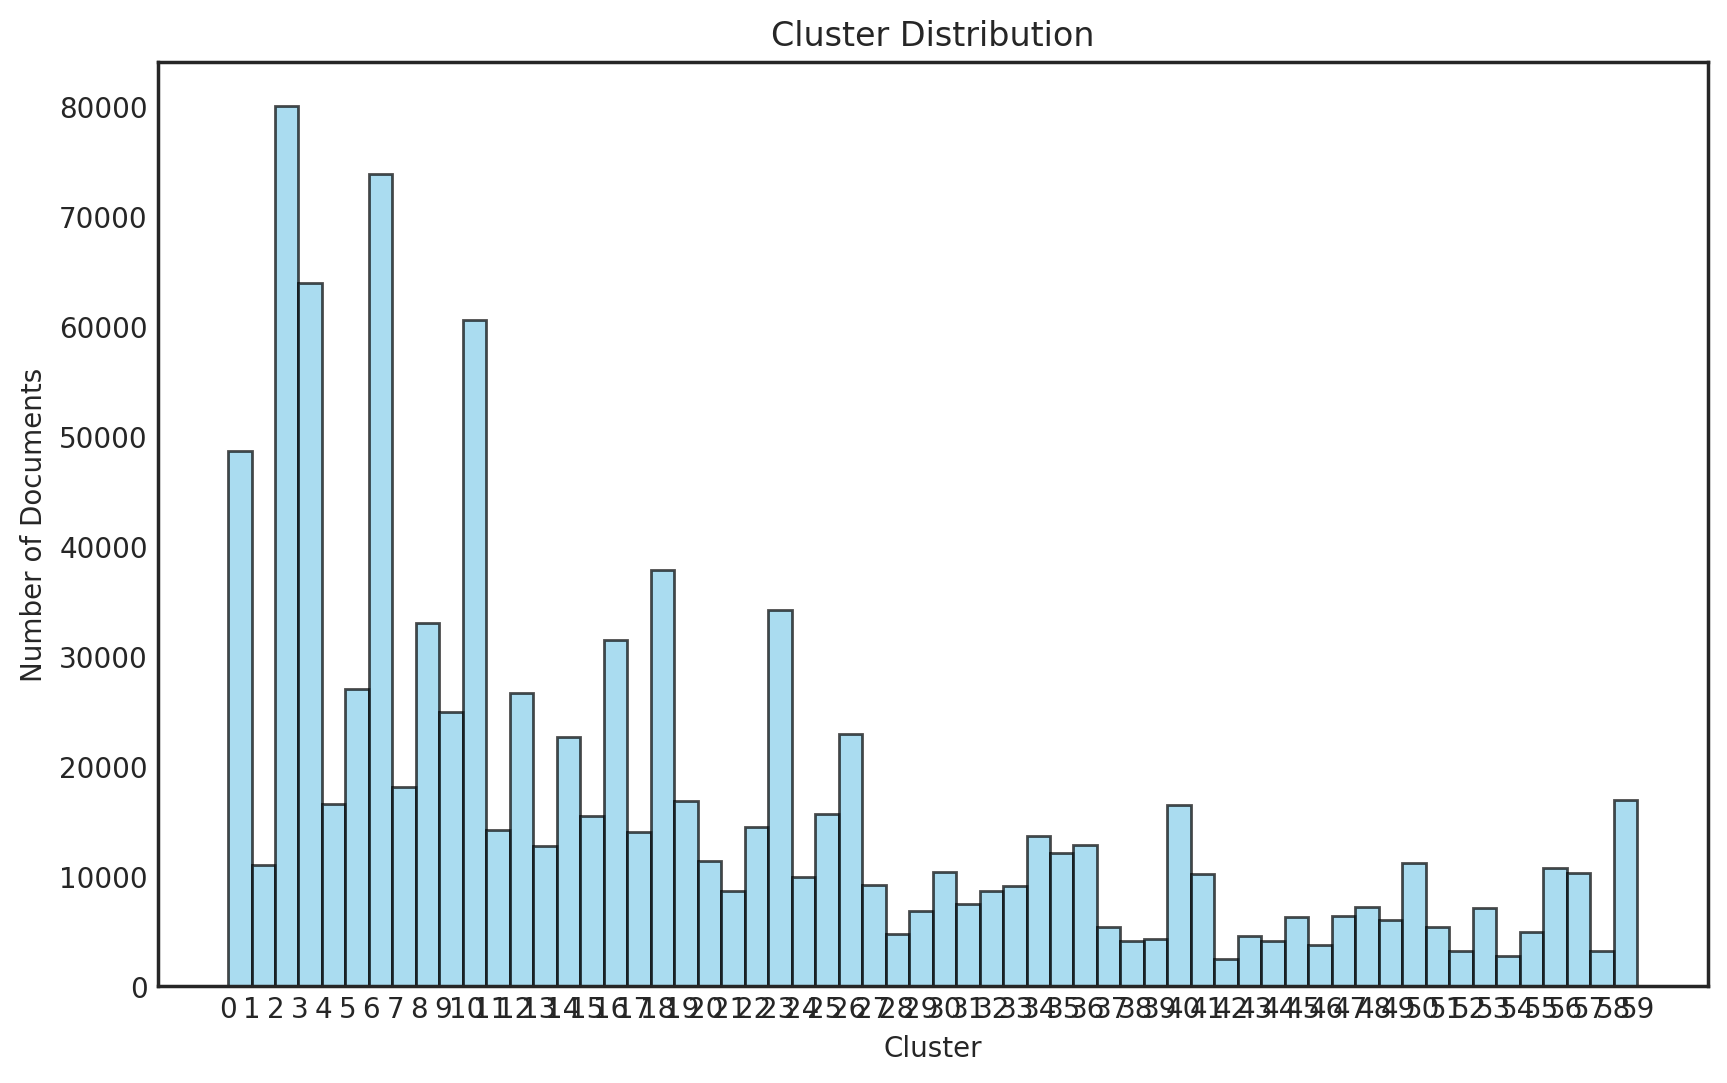

In [22]:
description_pandas_df['Preprocessed_Description'].fillna('', inplace=True)

# numerical features
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(description_pandas_df['Preprocessed_Description'])

# shape of the resulting matrix
print("Shape of the feature matrix:", X.shape)

num_clusters = 60
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

cluster_labels = kmeans.labels_
description_pandas_df['Cluster'] = cluster_labels

plt.figure(figsize=(10, 6))
plt.hist(cluster_labels, bins=num_clusters, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Cluster')
plt.ylabel('Number of Documents')
plt.title('Cluster Distribution')
plt.xticks(range(num_clusters))
plt.show()

24/05/07 11:52:07 WARN TaskSetManager: Stage 160 contains a task of very large size (31667 KiB). The maximum recommended task size is 1000 KiB.


<Figure size 1000x600 with 0 Axes>

<BarContainer object of 60 artists>

Text(0.5, 0, 'Cluster')

Text(0, 0.5, 'Belts_ratio')

Text(0.5, 1.0, 'Ratio of Clusters on Belts_ratio')

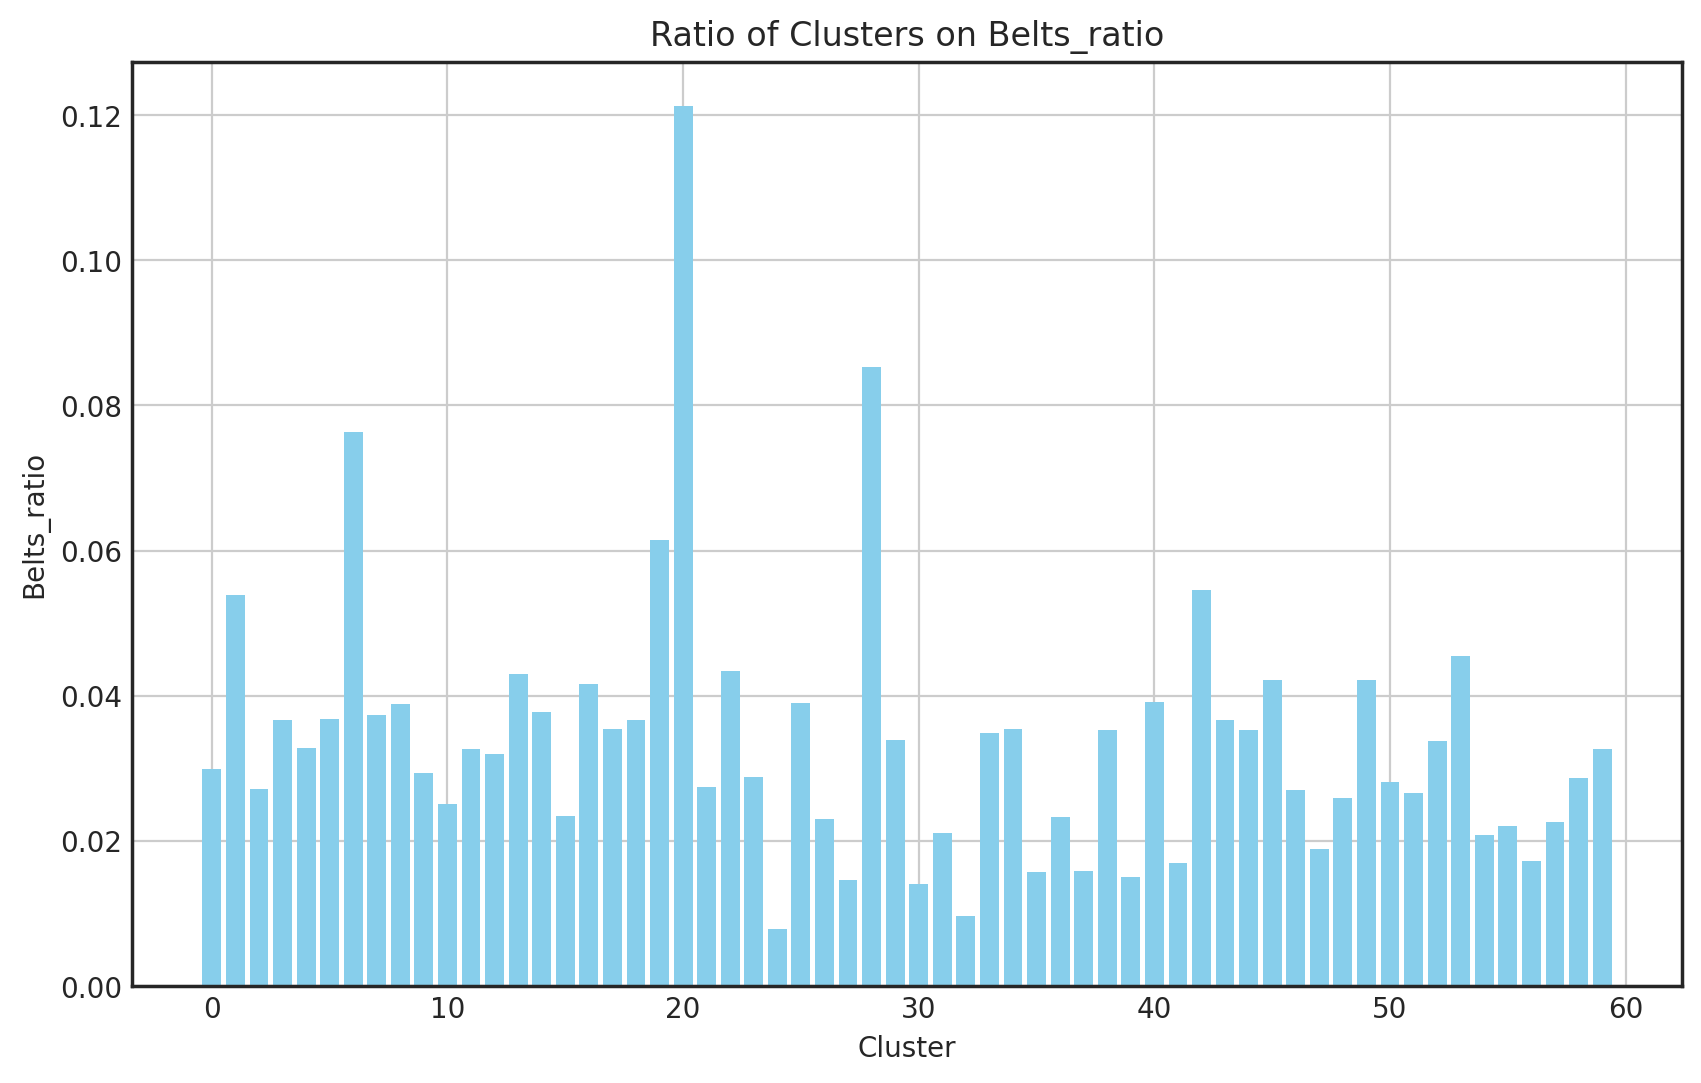

In [23]:
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.sql.functions import when, col

schema = StructType([
    StructField("index", StringType(), True),  # Add the index column
    StructField("Description", StringType(), True),
    StructField("Preprocessed_Description", StringType(), True),
    StructField("Cluster", StringType(), True)
])

description_spark_df = spark.createDataFrame(description_pandas_df.reset_index(), schema=schema)

# Add an index column to df
df_with_index = df.withColumn("index", monotonically_increasing_id())
joined_df = df_with_index.join(description_spark_df, df_with_index["index"] == description_spark_df["index"], "inner").drop("index")
joined_df = joined_df.withColumn("Cluster", joined_df["Cluster"].cast(IntegerType()))

# List of columns containing 'Yes' and 'No' values
yes_no_columns = ['Accident', 'Belts', 'Personal Injury', 'Property Damage', 'Fatal',
                  'Commercial License', 'HAZMAT', 'Commercial Vehicle', 'Alcohol', 'Work Zone']

# Function to convert 'Yes' to 1 and 'No' to 0
def encode_yes_no(value):
    return when(value == 'Yes', 1).otherwise(0)

# Apply the function to each relevant column
for col_name in yes_no_columns:
    joined_df = joined_df.withColumn(col_name, encode_yes_no(col(col_name)))

selected_columns = ['Cluster'] + yes_no_columns
selected_df = joined_df.select(selected_columns)
pandas_df = selected_df.toPandas()
cluster_sum_df = pandas_df.groupby('Cluster').sum()
cluster_count_df = pandas_df.groupby('Cluster').size().reset_index(name='count')
cluster_df = pd.merge(cluster_sum_df, cluster_count_df, on='Cluster')

ratio_col_list = []
for column in yes_no_columns:
    ratio_column_name = f"{column}_ratio"
    ratio_col_list.append(ratio_column_name)
    cluster_df[ratio_column_name] = cluster_df[column] / cluster_df['count']

for column_name in ["Belts_ratio"]:
    # Sort the DataFrame by the ratio column in descending order and select the top 10 clusters
    top_clusters = cluster_df.sort_values(by=column_name, ascending=False)

    # Plot the top 10 clusters with the highest ratios
    plt.figure(figsize=(10, 6))
    plt.bar(top_clusters['Cluster'], top_clusters[column_name], color='skyblue')
    plt.xlabel('Cluster')
    plt.ylabel(f'{column_name}')
    plt.title(f'Ratio of Clusters on {column_name}')
    plt.grid(True)
    plt.show()

## Clustering by Charge

In [24]:
df = spark.read.option("quote", '"').option("escape", '"').option("multiline", "true")\
    .csv("/kaggle/input/traffic-violations-in-usa/Traffic_Violations.csv", header=True, inferSchema=True)
desc_df = spark.read.option("quote", '"').option("escape", '"').option("multiline", "true")\
    .csv("/kaggle/working/description_data.csv", header=True, inferSchema=True)
df.count()
desc_df.count()

1018634

1018634

(0.0, 1.0, 0.0, 1.0)

(-0.05500000000000001,
 0.05500000000000001,
 -0.05500000000000001,
 0.05500000000000001)

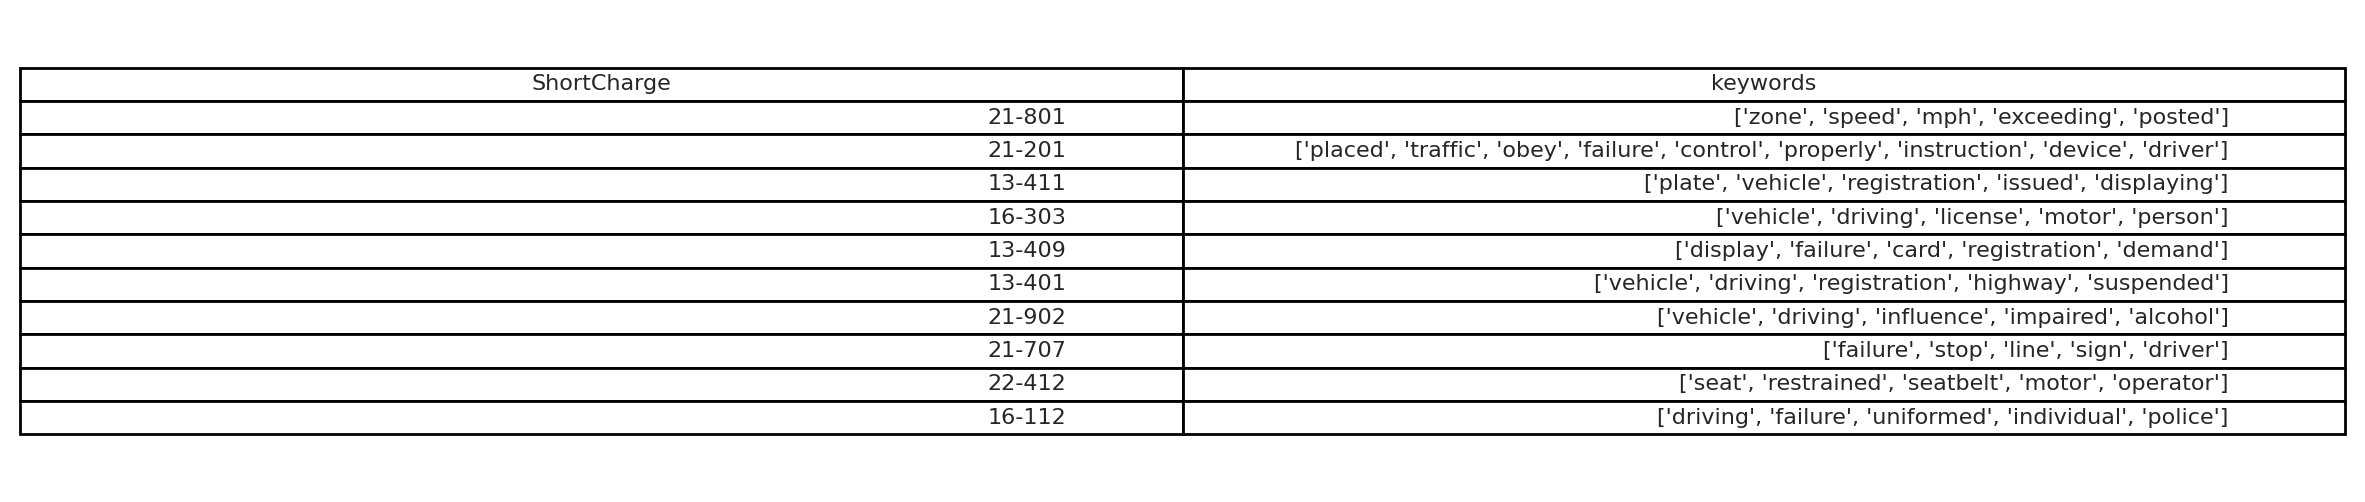

In [25]:
df = df.withColumn("index", F.monotonically_increasing_id())
desc_df = desc_df.withColumn("index", F.monotonically_increasing_id()).drop("Description")
df = df.join(desc_df, on=["index"]).drop("index")

def simplify_charge_impl(charge):
    if "-" in charge:
        dot_index = charge.find(".")
        if dot_index > -1:
            charge = charge[:dot_index]
        bracket_index = charge.find("(")
        if bracket_index > -1:
            charge = charge[:bracket_index]
    return charge

# spark.udf.register("simplify_charge", simplify_charge_impl, StringType())
simplify_charge = F.udf(simplify_charge_impl)
df = df.withColumn("ShortCharge", simplify_charge("Charge"))

word_count_df = df.withColumn("word", F.explode(F.split(F.col("Preprocessed_Description"), " ")))\
    .groupBy(["ShortCharge", "word"])\
    .count().sort("count", ascending=False)
window = Window.partitionBy(word_count_df["ShortCharge"]).orderBy(word_count_df["count"].desc())
word_count_df = word_count_df.select("*", F.rank().over(window).alias("rank"))\
    .filter(F.col("rank") <= 5)
word_count_df = word_count_df.groupBy("ShortCharge").agg(F.collect_set("word").alias("keywords"))
charge_count = df.groupBy("ShortCharge").count().orderBy("count", ascending=False)
word_count_df = word_count_df.join(charge_count, on=["ShortCharge"]).orderBy("count", ascending=False)
word_count_df = word_count_df.drop("count")

word_count_pd = word_count_df.toPandas()
# word_count_pd = word_count_pd.drop(columns=["count"])
word_count_pd = word_count_pd.drop(range(10, len(word_count_pd)))

fig, ax = plt.subplots()
fig.patch.set_visible(False)
fig.set_size_inches(15.0, 3.0)
ax.axis("off")
ax.axis("tight")
ax.table(cellText=word_count_pd.values, colLabels=word_count_pd.columns, loc="center")
plt.show()

+-----------+-----+---+-------------------+--------------------+
|ShortCharge|count|  1|         percentage|            keywords|
+-----------+-----+---+-------------------+--------------------+
|     20-107|   44| 30| 0.6818181818181818|[adm, accident, f...|
|     20-102|  432|237| 0.5486111111111112|[involving, accid...|
|     21-504|  206|110| 0.5339805825242718|[exercise, failur...|
|    21-1209|   23|  8|0.34782608695652173|[bike, failure, d...|
|     20-104| 1285|232|0.18054474708171206|[accident, lic, d...|
+-----------+-----+---+-------------------+--------------------+
only showing top 5 rows



<BarContainer object of 10 artists>

Text(0.5, 0, 'Type of Charge')

Text(0, 0.5, '% Personal Injury')

(0.0, 1.0, 0.0, 0.7159090909090908)

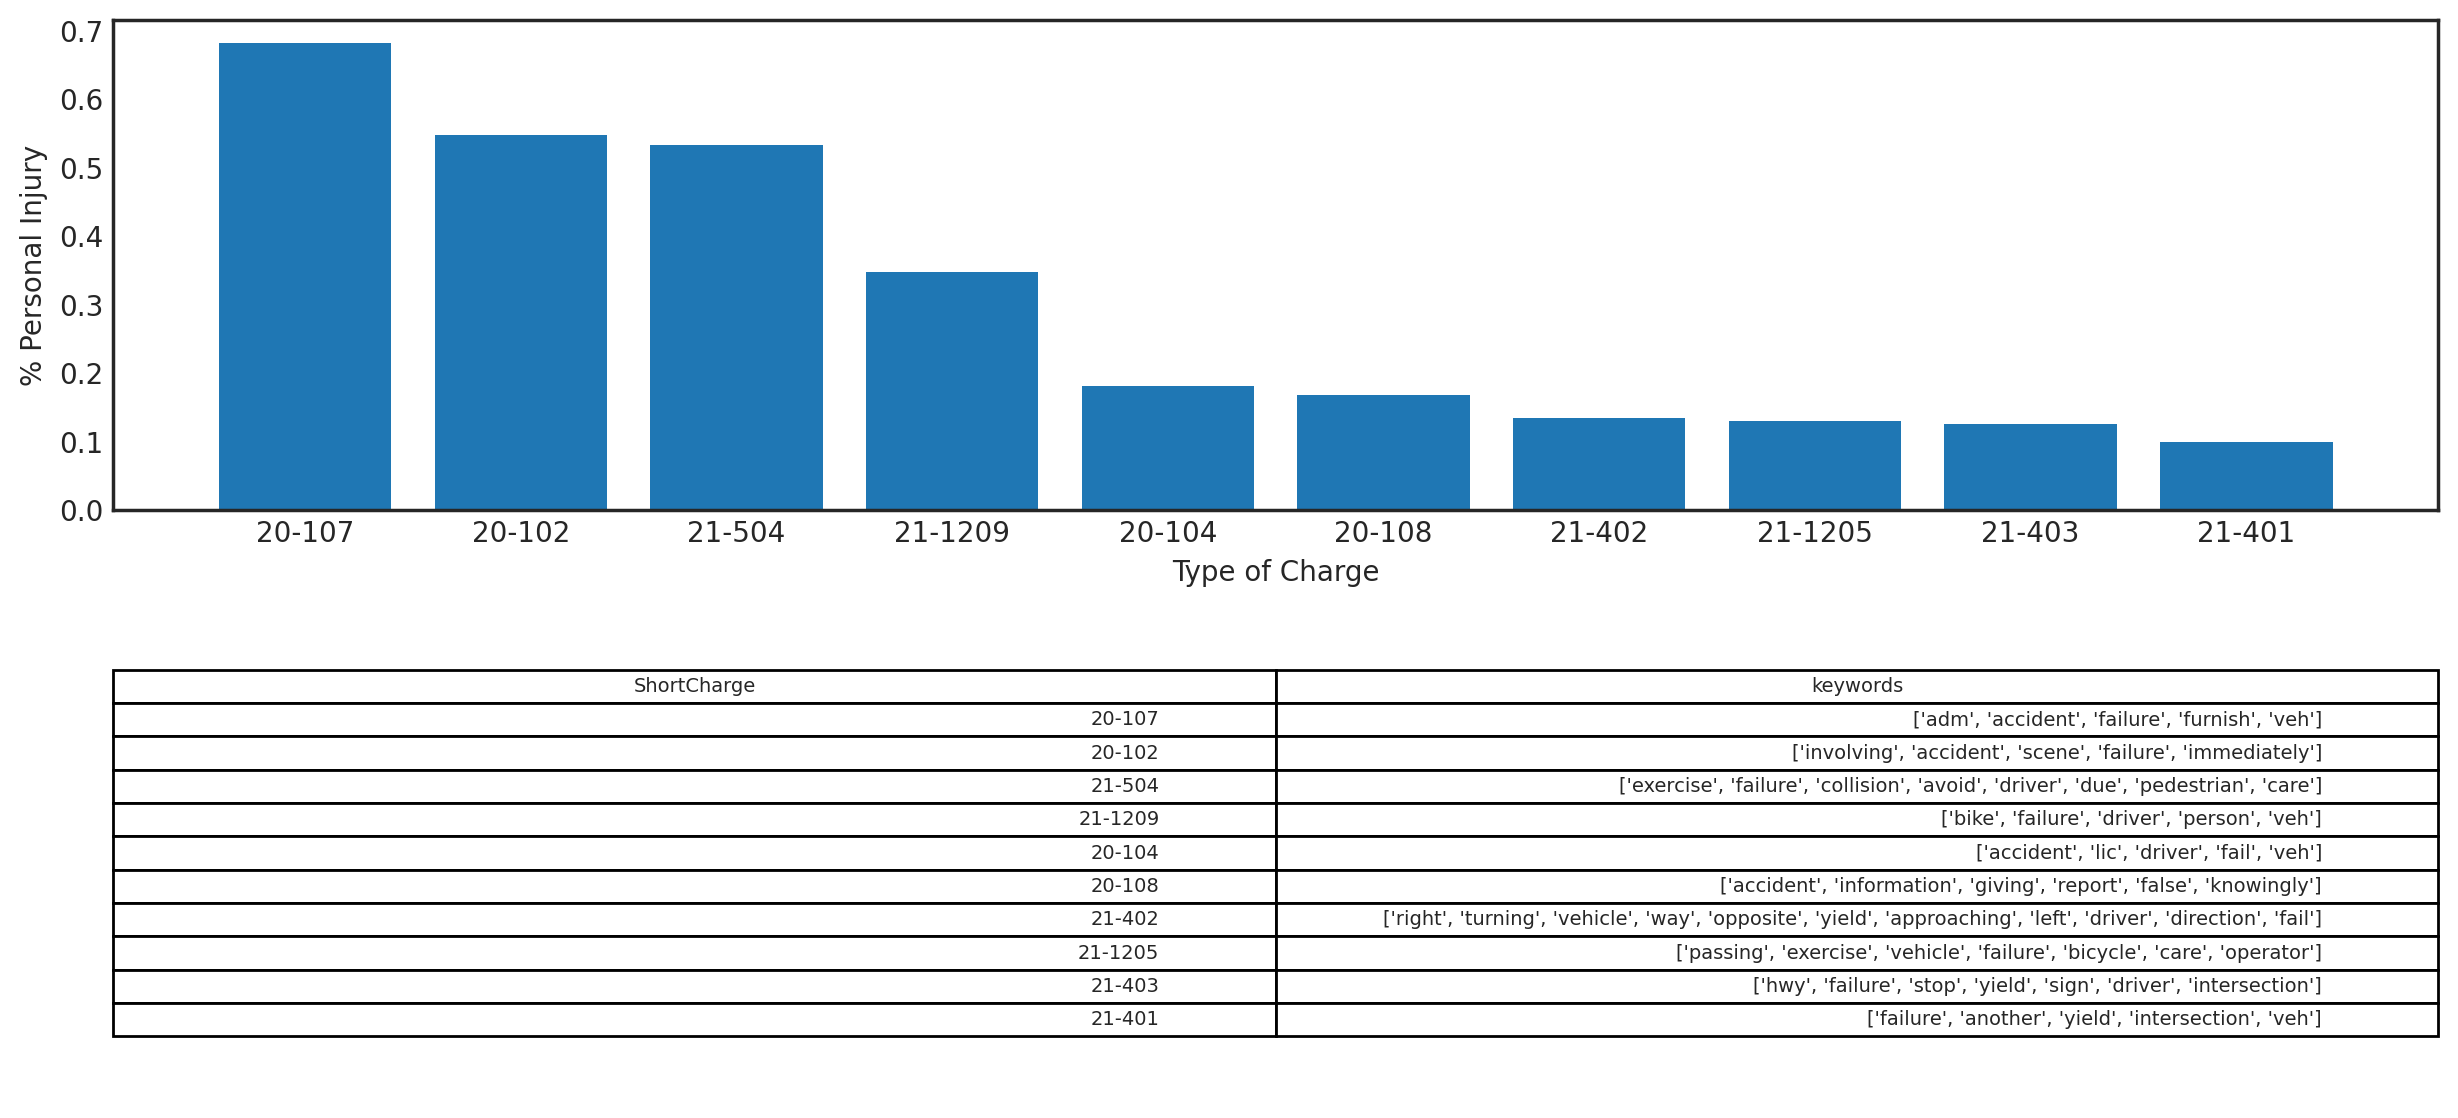

In [26]:
yes_no_columns = [
    "Personal Injury", "Property Damage", "Fatal",
    "Belts", "Commercial License", "Commercial Vehicle",
    "HAZMAT", "Alcohol", "Work Zone",
]

def encode_yes_no(value):
    return F.when(value == "Yes", 1).otherwise(0)

for col_name in yes_no_columns:
    df = df.withColumn(col_name, encode_yes_no(F.col(col_name)))
    pass

df = df.withColumn("Male", F.col("Gender") == "M").withColumn("Male", F.col("Male").cast(IntegerType()))
df = df.withColumn("Hour", F.hour("Time Of Stop"))
df = df.withColumn("Midnight", (F.col("Hour") < 6) | (F.col("Hour") >= 23)).withColumn("Midnight", F.col("Midnight").cast(IntegerType()))
yes_no_columns += ["Midnight", "Male"]

key = yes_no_columns[0]
group_df = df.groupBy("ShortCharge").count().orderBy("ShortCharge", ascending=True)
group_df = group_df.filter(F.col("count") > 10)
yes_df = df.groupBy("ShortCharge").pivot(key).count().orderBy("ShortCharge", ascending=True).fillna(0)
group_df = group_df.join(yes_df, on="ShortCharge").drop("0")
group_df = group_df.withColumn("percentage", F.col("1") / F.col("count"))
group_df = group_df.join(word_count_df, on=["ShortCharge"])
group_df = group_df.sort("percentage", ascending=False)
group_df.show(n=5)

group_pd = group_df.toPandas()
group_pd = group_pd.head(10)
fig, (ax1, ax2) = plt.subplots(2, 1, sharey=True)
fig.set_size_inches(15.0, 7.0)
ax1.bar(group_pd["ShortCharge"], group_pd["percentage"])
ax1.set_xlabel("Type of Charge")
ax1.set_ylabel(f"% {key}")
group_pd = group_pd.drop(columns=["count", "1", "percentage"])
ax2.table(cellText=group_pd.values, colLabels=group_pd.columns, loc="center")
ax2.axis("off")
plt.show()

+-----------+-----------------+
|ShortCharge|            speed|
+-----------+-----------------+
|     21-802|210.0540242557883|
|    21-1408|89.85637924954004|
+-----------+-----------------+
only showing top 2 rows



+-----------+------------+--------------------+--------------------+
|ShortCharge|Year Of Stop|          percentage|            keywords|
+-----------+------------+--------------------+--------------------+
|     13-936|        2014|1.832639761131051...|[vehicle, histori...|
|     13-936|        2013|1.627134301565723...|[vehicle, histori...|
+-----------+------------+--------------------+--------------------+
only showing top 2 rows



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

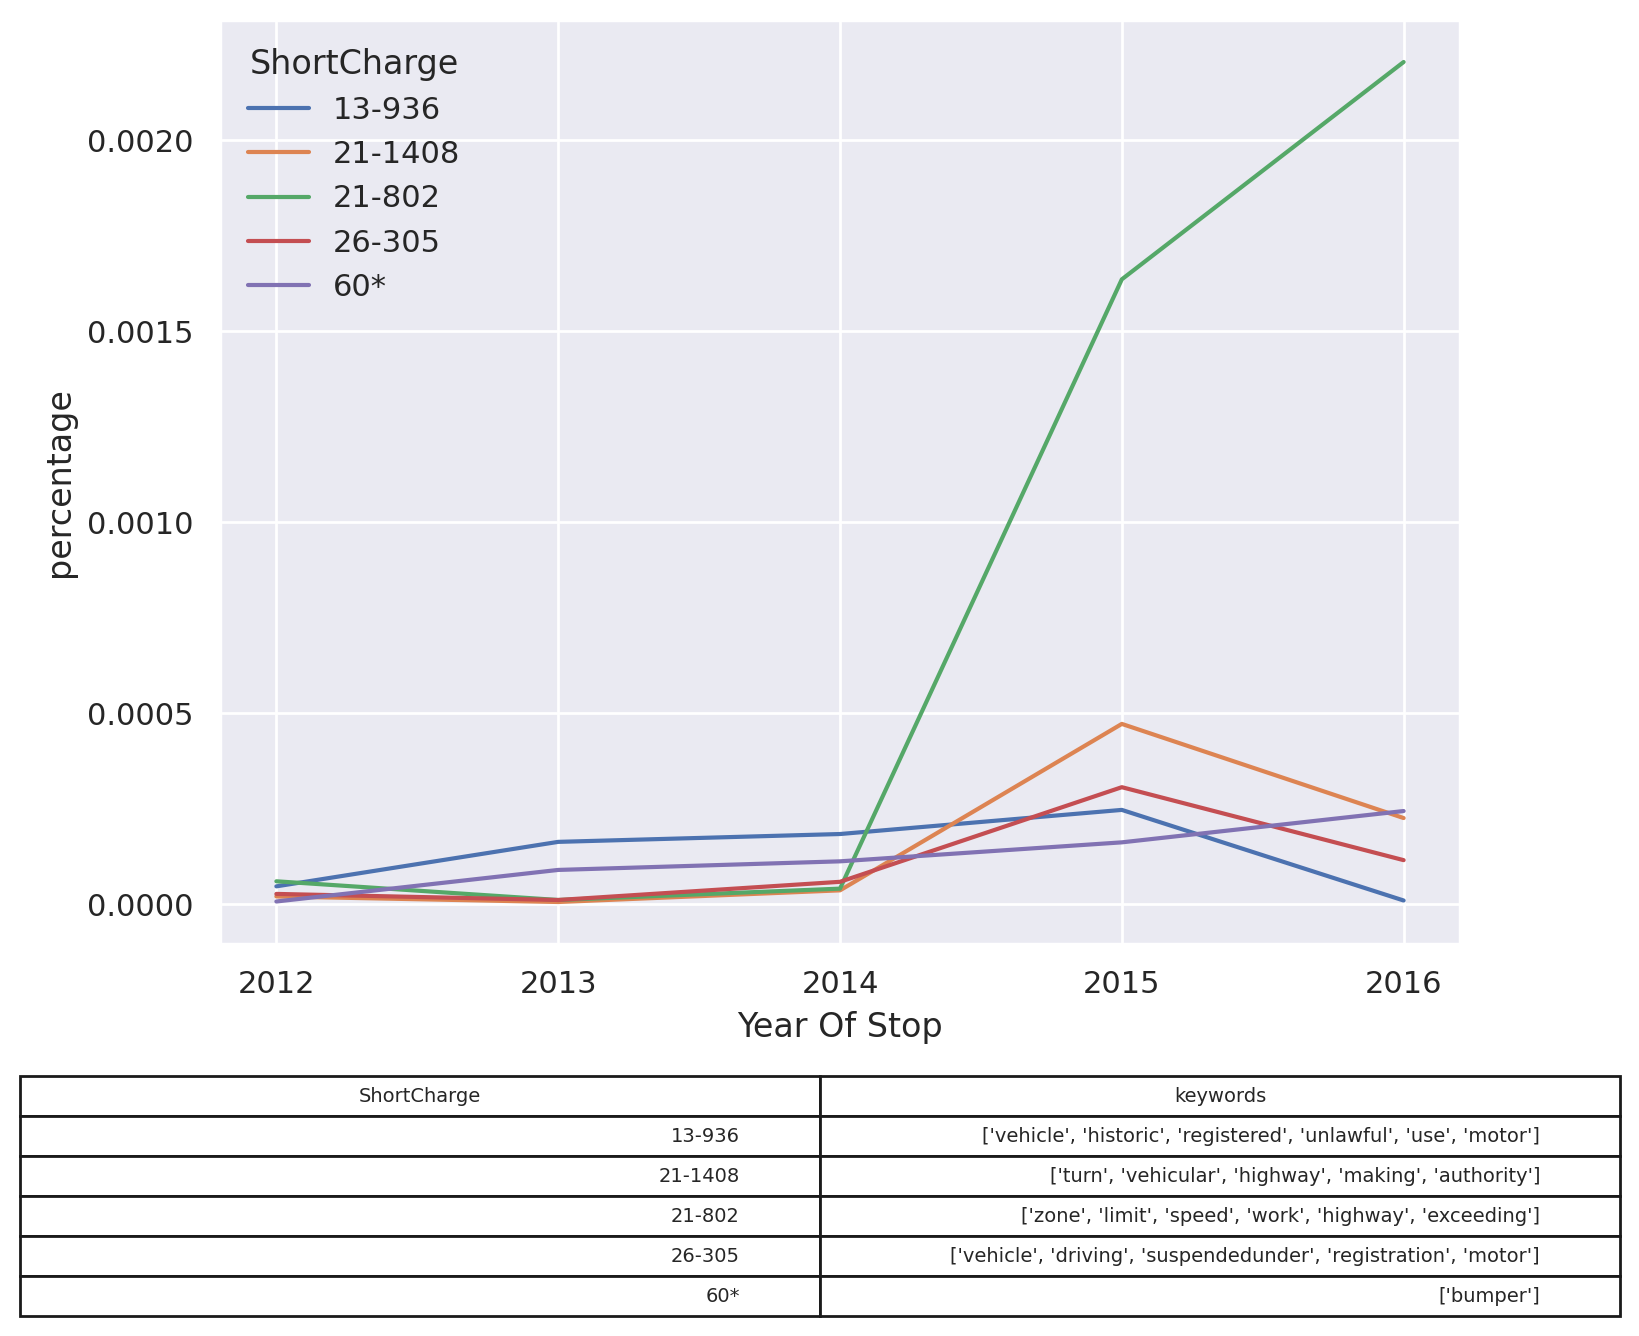

In [27]:
df = df.withColumn("Date Of Stop", F.to_date("Date Of Stop", "MM/dd/yyyy"))
df = df.withColumn("Year Of Stop", F.year("Date Of Stop"))

year_count = df.groupBy("Year Of Stop").count().orderBy("Year Of Stop", ascending=True)
charge_by_year_count = df.groupBy(["Year Of Stop", "ShortCharge"]).count().orderBy("Year Of Stop", ascending=True).withColumnRenamed("count", "charge_count")
charge_by_year_count = charge_by_year_count.join(year_count, on=["Year Of Stop"])
charge_by_year_count = charge_by_year_count.withColumn("percentage", F.col("charge_count") / F.col("count"))
charge_by_year_count = charge_by_year_count.orderBy(["Year Of Stop", "percentage"], ascending=[True, False])
charge_change_speed = charge_by_year_count.groupBy("ShortCharge").agg((F.max("percentage") / F.min("percentage")).alias("speed"))
charge_change_speed = charge_change_speed.orderBy("speed", ascending=False).limit(5)
charge_change_speed.show(n=2)
fastest_charges = charge_change_speed.toPandas()["ShortCharge"].to_list()
charge_by_year_count = charge_by_year_count.where(F.col("ShortCharge").isin(fastest_charges))
charge_by_year_count = charge_by_year_count.join(word_count_df, on=["ShortCharge"])
charge_by_year_count = charge_by_year_count.drop(*["charge_count", "count"])
charge_by_year_count.show(n=2)

charge_by_year_count_pd = charge_by_year_count.toPandas()
seaborn.set_theme(rc={'figure.figsize':(8.0, 6.0)})
ax = seaborn.lineplot(x="Year Of Stop", y="percentage", hue="ShortCharge", data=charge_by_year_count_pd)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
charge_by_year_count_pd = charge_by_year_count_pd.drop(columns=["Year Of Stop", "percentage"])
charge_by_year_count_pd = charge_by_year_count_pd.drop_duplicates(subset="ShortCharge")
plt.table(
    cellText=charge_by_year_count_pd.values,
    colLabels=charge_by_year_count_pd.columns,
    loc="center",
    transform=plt.gcf().transFigure,
    bbox = ([0.0, -0.2, 1.0, 0.2]),
)
plt.show()

0.010226389683441084

+-------+-----+-------+--------------------+
|Alcohol|    1|  count|          percentage|
+-------+-----+-------+--------------------+
|      0|11702|1016651|0.011510341306898828|
|      1|   72|   1983|0.036308623298033284|
+-------+-----+-------+--------------------+



<Axes: >

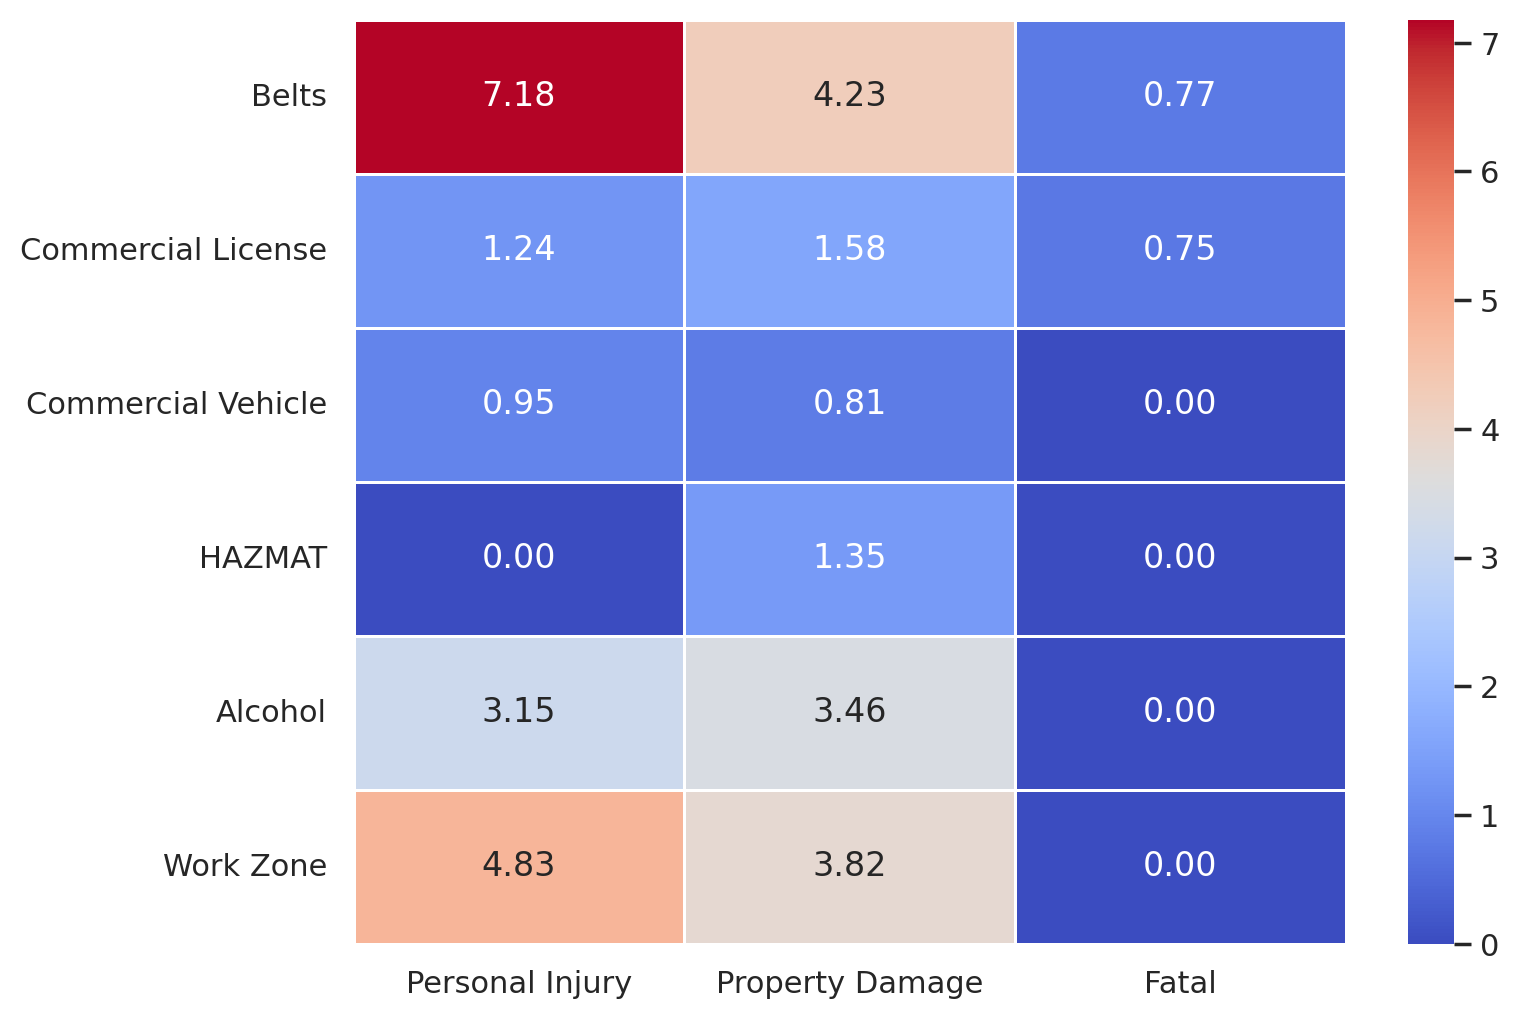

In [28]:
action_col = "Alcohol"
result_col = "Personal Injury"
df.corr(action_col, result_col)

ratio_df = df.where(F.col(action_col).isNotNull()).where(F.col(result_col).isNotNull())
action_true_count_df = ratio_df.groupBy(action_col).count()
ratio_df = ratio_df.groupBy(action_col).pivot(result_col).count().drop("0")
ratio_df = ratio_df.join(action_true_count_df, on=action_col)
ratio_df = ratio_df.withColumn("percentage", F.col("1") / F.col("count")).orderBy(action_col, ascending=True)
ratio_df.show()

result_cols = ["Personal Injury", "Property Damage", "Fatal"]
action_cols = [
    "Belts", "Commercial License", "Commercial Vehicle",
    "HAZMAT", "Alcohol", "Work Zone",
]
corr_table = np.zeros([len(action_cols), len(result_cols)], dtype=float)

for i in range(0, len(action_cols)):
    for j in range(0, len(result_cols)):
        action_col = action_cols[i]
        result_col = result_cols[j]
        ratio_df = df.where(F.col(action_col).isNotNull()).where(F.col(result_col).isNotNull())
        action_true_count_df = ratio_df.groupBy(action_col).count()
        ratio_df = ratio_df.groupBy(action_col).pivot(result_col).count().drop("0").fillna(0)
        ratio_df = ratio_df.join(action_true_count_df, on=action_col)
        ratio_df = ratio_df.withColumn("percentage", F.col("1") / F.col("count")).orderBy(action_col, ascending=True)
        ratio_pd = ratio_df.toPandas()
        corr_value = ratio_pd["percentage"][1] / ratio_pd["percentage"][0]
        corr_table[i, j] = corr_value

seaborn.heatmap(
    corr_table,
    annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5,
    xticklabels=result_cols,
    yticklabels=action_cols,
)

<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix of Columns')

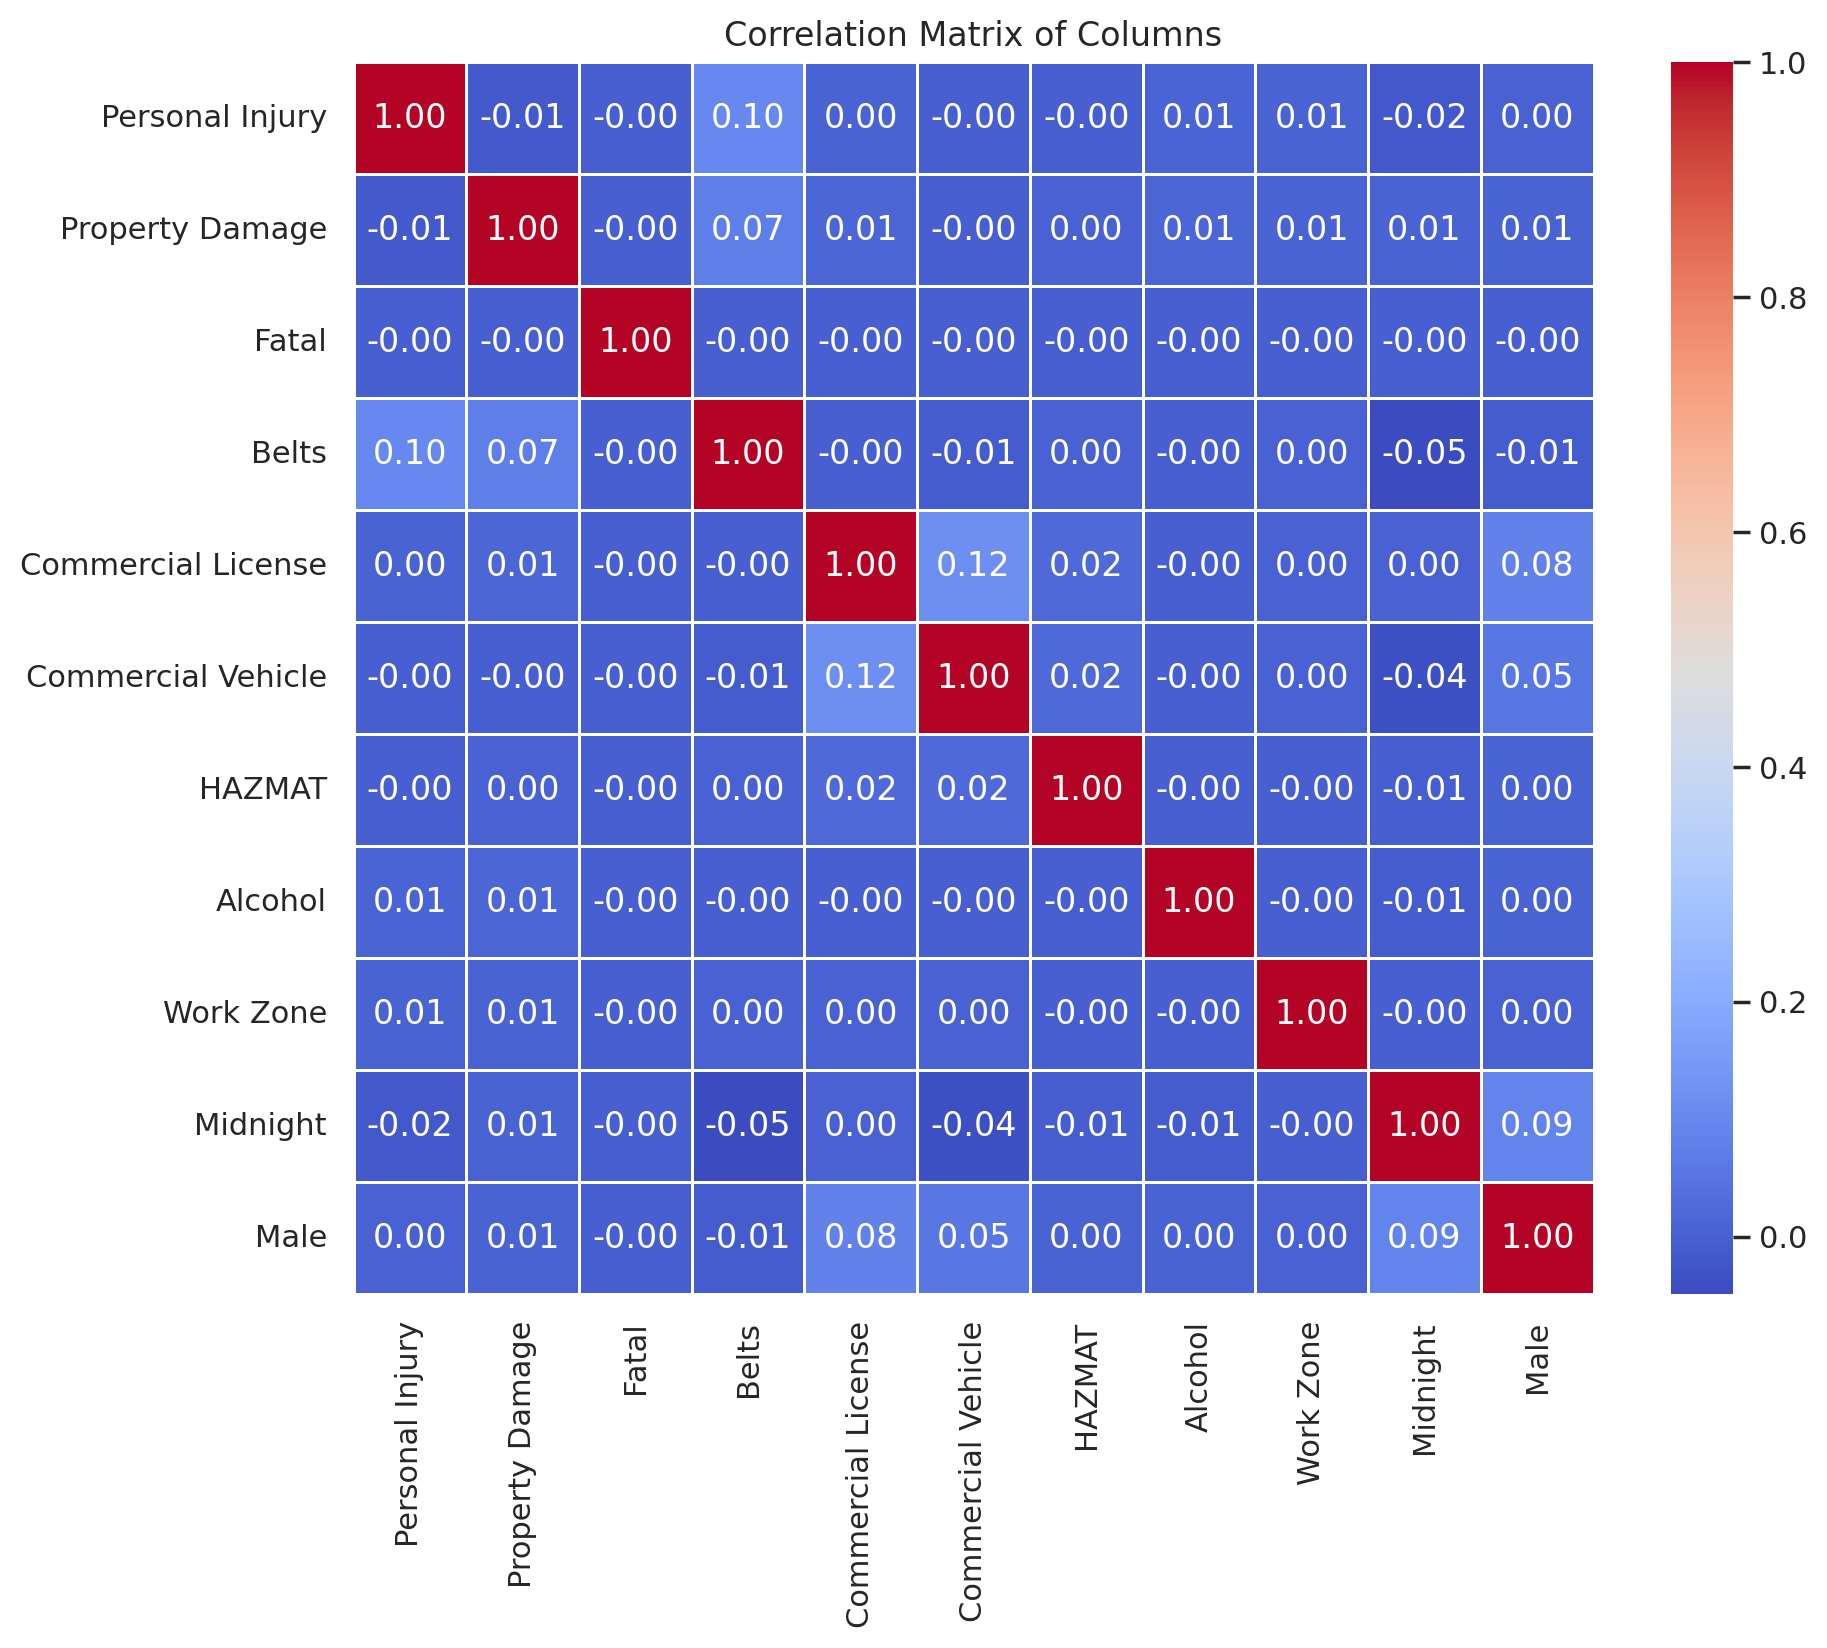

In [29]:
df = df.select([c for c in df.columns if c in yes_no_columns])
corr_df = df.toPandas()
correlation_matrix = corr_df[yes_no_columns].corr()

plt.figure(figsize=(10.0, 8.0))
seaborn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Columns')
plt.show()

## Classification

In [30]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder, StandardScaler, FeatureHasher
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline
from pyspark.sql.types import IntegerType, StringType

In [31]:
df = spark.read.option("quote", '"').option("escape", '"').option("multiline", "true")\
    .csv("/kaggle/input/traffic-violations-in-usa/Traffic_Violations.csv", header=True, inferSchema=True)

In [32]:
# Combine Electric Safety Equipment Repair Order with Safety Equipment Repair Order
df = df.replace("ESERO", "SERO", "Violation Type")
# Fix Make
df = df.replace("TOYT", "TOYOTA", "Make")
df = df.replace("HOND", "HONDA", "Make")
df = df.replace("NISS", "NISSAN", "Make")
df = df.replace("CHEV", "CHEVY", "Make")
df = df.replace("CHEVY", "CHEVROLET", "Make")
df = df.replace("HYUN", "HYUNDAI", "Make")
df = df.replace("ACUR", "ACURA", "Make")
df = df.replace("MERZ", "MERCEDES", "Make")
df = df.replace("LEXU", "LEXUS", "Make")
# DateTime conversion
df = df.withColumn("Date Of Stop", F.to_date("Date Of Stop", "MM/dd/yyyy"))
df = df.withColumn("Time Of Stop", F.to_timestamp("Time Of Stop", "HH:mm:ss"))
df = df.withColumn("Year Of Stop", F.year("Date Of Stop"))
df = df.withColumn("Month", F.month("Date Of Stop"))
df = df.withColumn("Weekday", F.dayofweek("Date Of Stop"))
df = df.withColumn("Hour", F.hour("Time Of Stop"))

In [33]:
def simplify_charge_impl(charge):
    if "-" in charge:
        dot_index = charge.find(".")
        if dot_index > -1:
            charge = charge[:dot_index]
        bracket_index = charge.find("(")
        if bracket_index > -1:
            charge = charge[:bracket_index]
    return charge

def simplify_color_impl(color):
    if color is None:
        return "NONE"
    elif "," in color:
        index = color.find(",")
        color = color[:index]
    return color

simplify_charge = F.udf(simplify_charge_impl)
df = df.withColumn("ShortCharge", simplify_charge("Charge"))
simplify_color = F.udf(simplify_color_impl)
df = df.withColumn("Color", simplify_color("Color"))
df = df.drop(*[
    "Date Of Stop", "Time Of Stop",
    "Agency",
    "Description", "Location",
    "Latitude", "Longitude",
    "Accident",
    "Model",
    "Charge",
    "Geolocation",
])

In [34]:
"""
feature_columns = df.columns
label_column = "Violation Type"
print(feature_columns)

continuous_columns = ["Year", "Month", "Hour"]
hash_columns = ["ShortCharge", "State", "Driver State", "DL State", "Driver City", "Make"]
binary_columns = [c for c in feature_columns if c not in (continuous_columns + hash_columns + [label_column])]
feature_columns.remove(label_column)

continuous_vector_assembler = VectorAssembler(
    inputCols=[c for c in continuous_columns],
    outputCol="continuous_features",
    handleInvalid="skip",
)
transformed_df = continuous_vector_assembler.transform(df)
num_hash_dict = {
    "ShortCharge": 128,
    "Driver City": 128,
    "Make": 256,
}

for column in binary_columns + hash_columns + ["continuous_features", label_column]:
    if column == label_column:
        indexer = StringIndexer(inputCol=column, outputCol=f"indexed_{column}", handleInvalid="skip")
        transformed_df = indexer.fit(transformed_df).transform(transformed_df)
    elif column in binary_columns:
        indexer = StringIndexer(inputCol=column, outputCol=f"indexed_{column}", handleInvalid="skip")
        transformed_df = indexer.fit(transformed_df).transform(transformed_df)
        oh_encoder = OneHotEncoder(inputCol=f"indexed_{column}", outputCol=f"oh_{column}")
        transformed_df = oh_encoder.fit(transformed_df).transform(transformed_df)
    elif column in hash_columns:
        num_hash = num_hash_dict.get(column, 32)
        indexer = StringIndexer(inputCol=column, outputCol=f"indexed_{column}", handleInvalid="skip")
        transformed_df = indexer.fit(transformed_df).transform(transformed_df)
        hasher = FeatureHasher(
            numFeatures=num_hash,
            inputCols=[f"indexed_{column}"], categoricalCols=[f"indexed_{column}"],
            outputCol=f"oh_{column}",
        )
        transformed_df = hasher.transform(transformed_df)
    elif column in ["continuous_features"]:
        scaler = StandardScaler(inputCol="continuous_features", outputCol=f"scaled_features", withMean=True, withStd=True)
        transformed_df = scaler.fit(transformed_df).transform(transformed_df)
    else:
        print(column)

vector_assembler = VectorAssembler(
    inputCols=[f"oh_{c}" for c in (binary_columns + hash_columns)] + ["scaled_features"],
    outputCol="features",
    handleInvalid="skip",
)
vectorized_df = vector_assembler.transform(transformed_df)
vectorized_df = vectorized_df.withColumnRenamed("indexed_Violation Type", "label")
dataset = vectorized_df.select("features", "label")
"""

'\nfeature_columns = df.columns\nlabel_column = "Violation Type"\nprint(feature_columns)\n\ncontinuous_columns = ["Year", "Month", "Hour"]\nhash_columns = ["ShortCharge", "State", "Driver State", "DL State", "Driver City", "Make"]\nbinary_columns = [c for c in feature_columns if c not in (continuous_columns + hash_columns + [label_column])]\nfeature_columns.remove(label_column)\n\ncontinuous_vector_assembler = VectorAssembler(\n    inputCols=[c for c in continuous_columns],\n    outputCol="continuous_features",\n    handleInvalid="skip",\n)\ntransformed_df = continuous_vector_assembler.transform(df)\nnum_hash_dict = {\n    "ShortCharge": 128,\n    "Driver City": 128,\n    "Make": 256,\n}\n\nfor column in binary_columns + hash_columns + ["continuous_features", label_column]:\n    if column == label_column:\n        indexer = StringIndexer(inputCol=column, outputCol=f"indexed_{column}", handleInvalid="skip")\n        transformed_df = indexer.fit(transformed_df).transform(transformed_df)\

In [35]:
!cd /kaggle/working
!pip install gdown
!gdown 1wrYtU6uYxR1TKXKHfueSeWGMbbWTls3y
!gdown 1VqFWwjogbCh7ymoVI2mL59zs8mfiK1zB

Downloading...
From: https://drive.google.com/uc?id=1wrYtU6uYxR1TKXKHfueSeWGMbbWTls3y
To: /kaggle/working/test.parquet
100%|██████████████████████████████████████| 4.31M/4.31M [00:00<00:00, 68.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VqFWwjogbCh7ymoVI2mL59zs8mfiK1zB
To: /kaggle/working/train.parquet
100%|██████████████████████████████████████| 9.00M/9.00M [00:00<00:00, 46.1MB/s]


In [36]:
# (training_data, test_data) = dataset.randomSplit([0.7, 0.3])
# training_data.write.parquet("/kaggle/working/train.parquet")
# test_data.write.parquet("/kaggle/working/test.parquet")
training_data = spark.read.parquet("/kaggle/working/train.parquet")
test_data = spark.read.parquet("/kaggle/working/test.parquet")

In [37]:
oversampled_minority = training_data.filter(F.col("label") == 2).sample(
    withReplacement=True, fraction=50.0, seed=11111)
training_data = training_data.filter(F.col("label") != 2).union(oversampled_minority)

In [38]:
# classifier = FMClassifier(factorSize=64, maxIter=100, miniBatchFraction=1.0, regParam=0.0, stepSize=0.1)
# classifier = GBTClassifier(maxDepth=16, maxIter=20)
# classifier = OneVsRest(classifier=classifier)
classifier = MultilayerPerceptronClassifier(blockSize=32, maxIter=30, layers=[718, 256, 3], stepSize=0.01)
model = classifier.fit(training_data)

24/05/07 12:04:34 WARN MemoryStore: Not enough space to cache rdd_2170_0 in memory! (computed 387.4 MiB so far)
24/05/07 12:04:34 WARN BlockManager: Persisting block rdd_2170_0 to disk instead.
24/05/07 12:04:47 WARN MemoryStore: Not enough space to cache rdd_2170_0 in memory! (computed 387.4 MiB so far)
24/05/07 12:04:53 WARN MemoryStore: Not enough space to cache rdd_2170_0 in memory! (computed 387.4 MiB so far)
24/05/07 12:04:53 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/07 12:07:13 WARN MemoryStore: Not enough space to cache rdd_2170_0 in memory! (computed 387.4 MiB so far)
24/05/07 12:09:39 WARN MemoryStore: Not enough space to cache rdd_2170_0 in memory! (computed 387.4 MiB so far)
24/05/07 12:12:06 WARN MemoryStore: Not enough space to cache rdd_2170_0 in memory! (computed 387.4 MiB so far)
24/05/07 12:14:33 WARN MemoryStore: Not enough space to cache rdd_2170_0 in memory! (computed 387.4 MiB so far)
24/05/07 12:16:59 WARN Memo

In [39]:
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
acc_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
predictions = model.transform(test_data)
metric_value = f1_evaluator.evaluate(predictions)
print("Metric on test data = %g" % metric_value)
metric_value = acc_evaluator.evaluate(predictions)
print("Metric on test data = %g" % metric_value)

24/05/07 13:29:24 WARN DAGScheduler: Broadcasting large task binary with size 1551.5 KiB
24/05/07 13:30:50 WARN DAGScheduler: Broadcasting large task binary with size 1551.5 KiB


Metric on test data = 0.70322


Metric on test data = 0.703373
